<a href="https://colab.research.google.com/github/AfsanehHabibi/reddit-conversation-quality/blob/main/Conversation_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_path = "/content/drive/MyDrive/University/RedditData/"

In [3]:
import pickle

with open(f"{base_path}conversations_remove_empty_with_topics_dataframe.pkl", 'rb') as file:
    df = pickle.load(file)

In [4]:
df = df.rename(columns={'politensess': 'politeness'})

In [5]:
import numpy as np

df['subreddit_subscribers'] = df['subreddit_subscribers'].replace(0, np.nan)

In [6]:
#Removing the comments we don't know their reply_to( most of these comments except 21 of them we don't have their post either)
df = df[~(df['reply_to'].isnull() & (df['id'] != df['conversation_id']))]

In [7]:
#Removes comments that their conversation is not in data
convs = df.loc[df['reply_to'].isnull()]['id'].unique()
df = df[df['conversation_id'].isin(convs)]

In [8]:
len(df)

217397

In [9]:
df['id'].nunique()

217397

#Column addition

In [10]:
df['reply_to'].nunique()

99976

In [11]:
def add_mean_for_reply(df, column):
  replies_df = df.loc[df['reply_to'].notnull()]
  mean_column = replies_df.groupby('reply_to')[column].mean()
  df = df.merge(mean_column.rename('mean_' + column + '_replies'), left_on='id', right_index=True, how='left')
  return df

In [12]:
def add_mean_for_conversation(df, column):
  replies_df = df.loc[df['reply_to'].notnull()]
  mean_column = replies_df.groupby('conversation_id')[column].mean()
  df = df.merge(mean_column.rename('mean_' + column + '_conv'), left_on='id', right_index=True, how='left')
  return df

In [13]:
def add_comment_count_for_conversation(df):
  replies_df = df.loc[df['reply_to'].notnull()]
  count_column = replies_df.groupby('conversation_id')['id'].nunique()
  df = df.merge(count_column.rename('comments_count_conv'), left_on='id', right_index=True, how='left')
  return df

In [14]:
df = add_comment_count_for_conversation(df)

In [15]:
df = add_mean_for_conversation(df, 'norm_readability')
df = add_mean_for_conversation(df, 'norm_politeness')
df = add_mean_for_conversation(df, 'relatedness')
df = add_mean_for_conversation(df, 'evidence')
df = add_mean_for_conversation(df, 'has_reasoning')

In [16]:
df = add_mean_for_reply(df, 'norm_readability')
df = add_mean_for_reply(df, 'norm_politeness')
df = add_mean_for_reply(df, 'relatedness')
df = add_mean_for_reply(df, 'evidence')
df = add_mean_for_reply(df, 'has_reasoning')

In [17]:
maxims = ['norm_readability', 'norm_politeness', 'has_reasoning', 'evidence', 'relatedness']

In [18]:
maxim_mean_over_replies = ['mean_norm_readability_replies', 'mean_norm_politeness_replies', 'mean_has_reasoning_replies', 'mean_evidence_replies', 'mean_relatedness_replies']

In [19]:
maxim_mean_over_conversations = ['mean_norm_readability_conv', 'mean_norm_politeness_conv', 'mean_has_reasoning_conv', 'mean_evidence_conv', 'mean_relatedness_conv']

In [20]:
def add_string_length(df, column):
    df['len_'+column] = df[column].apply(lambda x: len(x) if isinstance(x, str) else np.nan)
    return df

In [21]:
df = add_string_length(df, 'title')
df = add_string_length(df, 'text')

In [22]:
import numpy as np

def add_log(df, column):
  df['log_'+column] = np.log(df[column])
  return df

In [23]:
df = add_log(df, 'subreddit_subscribers')

In [24]:
def add_depth(df):
  df['depth'] = float('nan')
  df.loc[df['reply_to'].isnull(), 'depth'] = 0
  last_level = df.loc[df['depth']==0]['id'].unique()
  for i in range(1, 80):
    df.loc[df['reply_to'].isin(last_level), 'depth'] = i
    last_level = df.loc[df['depth'] == i]['id'].unique()
  df['depth'] = df['depth'].fillna(-1).astype(int)

In [25]:
def add_merged_depth(df):
  depth_counts = df[df['depth'] != -1]['depth'].value_counts()
  depth_counts = depth_counts.sort_values(ascending=True)
  depth_sum = depth_counts.cumsum()
  new_depth = {}
  new_depth[-1] = -1
  last = len(depth_sum) - 1
  sum = 0
  for j in range(len(depth_sum)-1, -1, -1):
    if depth_counts[j] >= 30:
      new_depth[j] = j
    else:
      if sum + depth_counts[j] >= 30:
        new_depth[j] = last
        sum = 0
        last = j
      else:
        sum += depth_counts[j]
        new_depth[j] = last
  df['merged_depth'] = [new_depth.get(x) for x in df['depth']]

In [26]:
add_depth(df)

In [27]:
add_merged_depth(df)

In [28]:
df.head()

,id,conversation_id,reply_to,readability,evidence,has_reasoning,has_reasoning_one_shot,politeness,relatedness,subjectivity,...,mean_norm_readability_replies,mean_norm_politeness_replies,mean_relatedness_replies,mean_evidence_replies,mean_has_reasoning_replies,len_title,len_text,log_subreddit_subscribers,depth,merged_depth
0,xyt38s,xyt38s,None,-0.5,0.5,0,0.785905,0.095238,NaN,0.532381,...,0.65,0.058824,0.306438,0.333333,0.0,12.0,280,8.821732,0,0
1,iromk5a,xyt38s,xyt38s,-0.5,0.5,0,0.725411,0.095238,0.887727,0.532381,...,NaN,NaN,NaN,NaN,NaN,NaN,276,8.821732,1,1
2,irpc624,xyt38s,xyt38s,-4.5,0.5,0,0.882337,0.000000,0.031587,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,60,8.821732,1,1
3,irp3pvs,xyt38s,xyt38s,-5.5,0.0,0,0.968893,0.047619,0.000000,0.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,19,8.821732,1,1
4,xyt38b,xyt38b,None,-2.5,0.5,1,0.390972,0.380952,NaN,0.415179,...,1.00,0.294118,0.262232,0.500000,1.0,66.0,694,14.904485,0,0


#Plots

##Histogram

In [29]:
def plot_histogram(df, column):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[column], bins=range(df[column].min(), df[column].max() + 1), kde=False)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')
    plt.show()

##Scatter plot

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def scatter(df, column1, column2):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=column1, y=column2, data=df)
    plt.xlabel(f'{column1}')
    plt.ylabel(f'{column2}')
    plt.title(f'Relationship between {column1} and {column2}')
    plt.show()


##Categorical

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def scatter_with_categorical(df, column1, column2):
    plt.figure(figsize=(10, 6))

    # Sort the unique categories in column1 by the mean of column2
    sorted_categories = df.groupby(column1)[column2].mean().sort_values(ascending=False).reset_index()

    print(sorted_categories)
    # Get the unique categories
    categories = sorted_categories[column1].unique()
    # Create the scatter plot with the categories sorted
    sns.scatterplot(x=column1, y=column2, data=sorted_categories, hue=column1)
    plt.xticks(rotation=90)
    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.title(f'Relationship between {column1} and {column2}')
    plt.tight_layout()
    plt.legend('', frameon=False)
    plt.show()

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def mean_markers_for_categorical_to_numerical(df, column1, column2):
    plt.figure(figsize=(10, 6))
    sns.stripplot(x=column1, y=column2, data=df, size=5, jitter=True)

    # Get the unique categories
    categories = df[column1].unique()

    # Calculate the mean for each category
    means = df.groupby(column1)[column2].mean().sort_values(ascending=False)

    # Set the x-axis tick labels
    plt.xticks(range(len(categories)), means.index, rotation=90)

    plt.title(f'Mean Markers for {column1} in respect to {column2}')
    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.tight_layout()

    plt.show()

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def boxplots_for_categorical_to_numerical(df, column1, column2):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column1, y=column2, data=df, fliersize=3)

    # Get the unique categories
    categories = df[column1].unique()

    # Set the x-axis tick labels
    #plt.xticks(range(len(categories)), categories, rotation=90)

    plt.title(f'Boxplot for {column1} in respect to {column2}')
    plt.xlabel(column1)
    plt.ylabel(column2)
    plt.tight_layout()

    # the number of points in each boxplot
    #for i, box in enumerate(df.groupby(column1)[column2]):
    #   print(box[1].shape[0])

    plt.show()

##Density plot

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def density_for_numeric_to_numeric(df, column1, column2):
    plt.figure(figsize=(8, 6))
    sns.jointplot(x=column1, y=column2, data=df, kind='kde', cmap='viridis')
    plt.suptitle(f'Density between Original {column1} and {column2}')
    plt.tight_layout()
    plt.show()

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def density_for_numeric_to_numeric_simple(df, column1, column2):
    df['density'] = np.log1p(df.groupby([column1, column2])[column1].transform('count'))

    # Create a dummy scatter plot for colorbar mappable
    dummy = plt.scatter([], [], c=[], cmap='viridis', alpha=0.6, label='Density')

    plt.figure(figsize=(10, 6))
    scatter = sns.scatterplot(x=column1, y=column2, hue='density', data=df, palette='viridis', alpha=0.6)
    plt.xlabel(f'{column1} of Original Row')
    plt.ylabel(f'{column2}')
    plt.title(f'Relationship between Original {column1} and {column2}')
    plt.colorbar(dummy)
    plt.legend()
    plt.show()

##Heatmap

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def heatmap(df, column1, column2):
  correlation = df[column1].corr(df[column2])

  plt.figure(figsize=(8, 6))
  sns.heatmap([[1, correlation], [correlation, 1]], annot=True, cmap='coolwarm', linewidths=.5, xticklabels=[column1, column2], yticklabels=[column1, column2])
  plt.title(f'Intensity Plot for Correlation between {column1} and {column2}')
  plt.show()

##Agreggation

In [37]:
#over correspond
def heatmap_and_density_for_correspond(column):
  density_for_numeric_to_numeric(df, column, 'norm_readability')
  heatmap_for_numeric_to_numeric(df, column, 'norm_readability')
  density_for_numeric_to_numeric(df, column, 'norm_politeness')
  heatmap_for_numeric_to_numeric(df, column, 'norm_politeness')
  density_for_numeric_to_numeric(df, column, 'has_reasoning')
  heatmap_for_numeric_to_numeric(df, column, 'has_reasoning')
  density_for_numeric_to_numeric(df, column, 'evidence')
  heatmap_for_numeric_to_numeric(df, column, 'evidence')
  density_for_numeric_to_numeric(df, column, 'relatedness')
  heatmap_for_numeric_to_numeric(df, column, 'relatedness')
  density_for_numeric_to_numeric(df, column, 'conv-unweighted')
  heatmap_for_numeric_to_numeric(df, column, 'conv-unweighted')
  density_for_numeric_to_numeric(df, column, 'conv-eq-maxim')
  heatmap_for_numeric_to_numeric(df, column, 'conv-eq-maxim')

In [38]:
#over mean of reply
def heatmap_and_density_for_maxims(column):
  density_for_numeric_to_mean_numeric(df, column, 'norm_readability')
  heatmap_for_numeric_to_mean_numeric(df, column, 'norm_readability')
  density_for_numeric_to_mean_numeric(df, column, 'norm_politeness')
  heatmap_for_numeric_to_mean_numeric(df, column, 'norm_politeness')
  density_for_numeric_to_mean_numeric(df, column, 'has_reasoning')
  heatmap_for_numeric_to_mean_numeric(df, column, 'has_reasoning')
  density_for_numeric_to_mean_numeric(df, column, 'evidence')
  heatmap_for_numeric_to_mean_numeric(df, column, 'evidence')
  density_for_numeric_to_mean_numeric(df, column, 'relatedness')
  heatmap_for_numeric_to_mean_numeric(df, column, 'relatedness')
  density_for_numeric_to_mean_numeric(df, column, 'conv-unweighted')
  heatmap_for_numeric_to_mean_numeric(df, column, 'conv-unweighted')
  density_for_numeric_to_mean_numeric(df, column, 'conv-eq-maxim')
  heatmap_for_numeric_to_mean_numeric(df, column, 'conv-eq-maxim')

In [39]:
def heatmap_and_density_for_strings_to_maxims(column):
  density_string_len_to_mean_numeric(df, column, 'norm_readability')
  heatmap_for_string_len_to_mean_numeric(df, column, 'norm_readability')
  density_string_len_to_mean_numeric(df, column, 'norm_politeness')
  heatmap_for_string_len_to_mean_numeric(df, column, 'norm_politeness')
  density_string_len_to_mean_numeric(df, column, 'has_reasoning')
  heatmap_for_string_len_to_mean_numeric(df, column, 'has_reasoning')
  density_string_len_to_mean_numeric(df, column, 'evidence')
  heatmap_for_string_len_to_mean_numeric(df, column, 'evidence')
  density_string_len_to_mean_numeric(df, column, 'relatedness')
  heatmap_for_string_len_to_mean_numeric(df, column, 'relatedness')
  density_string_len_to_mean_numeric(df, column, 'conv-unweighted')
  heatmap_for_string_len_to_mean_numeric(df, column, 'conv-unweighted')
  density_string_len_to_mean_numeric(df, column, 'conv-eq-maxim')
  heatmap_for_string_len_to_mean_numeric(df, column, 'conv-eq-maxim')

In [40]:
def mean_marker_to_mean_replies(column):
  for m in maxim_mean_over_replies:
    mean_markers_for_categorical_to_numerical(df, column, m)

In [41]:
def boxplot_to_mean_replies(column):
  for m in maxim_mean_over_replies:
    boxplots_for_categorical_to_numerical(df, column, m)

In [42]:
def boxplot_multiple(column, columns):
  for m in columns:
    boxplots_for_categorical_to_numerical(df, column, m)

#Statical test

##LM

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

def lm(df, column1, column2):
    df = df.dropna(subset=[column1, column2])

    correlation = df[column1].corr(df[column2])
    print("Pearson Correlation Coefficient: ", correlation)
    # Fit a linear regression model
    model = sm.OLS(df[column1], sm.add_constant(df[column2])).fit()

    # Get the fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(model.resid, model.model.exog)

    # Extract the test statistic and p-value
    bp_stat, bp_pvalue, f_pvalue, bp_fvalue = bp_test

    print(f"Breusch-Pagan Test for normality of residuals:")
    print(f"Test Statistic: {bp_stat:.4f}")
    print(f"P-value: {bp_pvalue:.4f}")

    # Check for autocorrelation using Durbin-Watson test
    dw_stat = durbin_watson(model.resid)
    print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

    if dw_stat < 1.5 or dw_stat > 2.5:
       print("Warning: Autocorrelation may be present in the model.")

    if bp_pvalue < 0.05:
        # Calculate weights based on the residuals
        weights = 1 / np.var(residuals)

        # Fit the WLS regression model
        wls_model = sm.WLS(df[column1], sm.add_constant(df[column2]), weights=weights).fit()

        summary_table = wls_model.summary()

        #if model.rsquared >= 0.025:
        if correlation >= 0.19:
          print("relatively signicent!")
          density_for_numeric_to_numeric(df, column1, column2)
        print(summary_table)
    else:
        summary_table = model.summary()

        #if model.rsquared >= 0.025:
        if correlation >= 0.19:
          print("relatively signicent!")
          density_for_numeric_to_numeric(df, column1, column2)
        print(summary_table)
    return model.rsquared

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

def lm_multiple(df, dependent_var, independent_vars):
    df = df.dropna(subset=independent_vars)
    df = df.dropna(subset=[dependent_var])

    # Fit a multiple linear regression model
    model = ols(formula=f"{dependent_var} ~ {' + '.join([col for col in independent_vars])}", data=df).fit()

    # Get the fitted values and residuals
    fitted_values = model.fittedvalues
    residuals = model.resid

    # Perform the Breusch-Pagan test
    bp_test = het_breuschpagan(model.resid, model.model.exog)

    # Extract the test statistic and p-value
    bp_stat, bp_pvalue, f_pvalue, bp_fvalue = bp_test

    # Print the results
    print(f"Breusch-Pagan Test:")
    print(f"Test Statistic: {bp_stat:.4f}")
    print(f"P-value: {bp_pvalue:.4f}")

    # Check for autocorrelation using Durbin-Watson test
    dw_stat = durbin_watson(model.resid)
    print(f"Durbin-Watson Statistic: {dw_stat:.4f}")

    if dw_stat < 1.5 or dw_stat > 2.5:
        print("Warning: Autocorrelation may be present in the model.")

    if bp_pvalue < 0.05:
        # Calculate weights based on the residuals
        weights = 1 / np.var(residuals)

        # Fit the WLS regression model
        wls_model = sm.WLS(df[dependent_var], sm.add_constant(df[[col for col in independent_vars]]), weights=weights).fit()

        if model.rsquared >= 0.1:
          print("relatively signicent!")
        # Create a table with estimates, standard errors, t-values, and p-values
        summary_table = wls_model.summary()

        # Print the summary table
        print(summary_table)
    else:
        # Create a table with estimates, standard errors, t-values, and p-values
        summary_table = model.summary()

        if model.rsquared >= 0.1:
          print("relatively signicent!")
        # Print the summary table
        print(summary_table)


##2 sample test

In [45]:
from scipy.stats import skew, kurtosis, kurtosistest

def is_normally_distributed(column, group1, group2):
  plt.figure(figsize=(8, 6))

  plt.subplot(121)
  plt.hist(group1[column].dropna(), bins=50, alpha=0.5, label='Group 1')
  plt.legend()
  plt.title('Group 1')

  plt.subplot(122)
  plt.hist(group2[column].dropna(), bins=50, alpha=0.5, label='Group 2')
  plt.legend()
  plt.title('Group 2')
  plt.show()

  res1 = stats.anderson(group1[column].dropna(), dist='norm')
  res2 = stats.anderson(group2[column].dropna(), dist='norm')

  print(f"Group 1 normality statistic: {res1.statistic:.4f}")
  print("Group 1 critical values:", res1.critical_values)
  print(f"Group 2 normality statistic: {res2.statistic:.4f}")
  print("Group 2 critical values:", res2.critical_values)

  skewness1 = skew(group1[column].dropna())
  kurtosis_value1 = kurtosis(group1[column].dropna())
  skewness2 = skew(group2[column].dropna())
  kurtosis_value2 = kurtosis(group2[column].dropna())
  print(f"Group 1 skewness: {skewness1:.4f} kurtosis: {kurtosis_value1:.4f}")
  print(f"Group 2 skewness: {skewness2:.4f} kurtosis: {kurtosis_value2:.4f}")

  if skewness1 < 0.1 and kurtosis_value1 < 3.1 and skewness2 < 0.1 and kurtosis_value2 < 3.1:
    print("The data is normally distributed by Skewness-Kurtosis All Normality Test.")
  else:
    print("The data is not normally distributed by Skewness-Kurtosis All Normality Test.")

  if res1.statistic < res1.critical_values[4] and res2.statistic < res2.critical_values[4]:
    print("The data is normally distributed by Anderson Darling normality Test.")
    return True
  print("The data is not normally distributed by Anderson Darling normality Test.")
  return False

In [46]:
import pandas as pd
from scipy.stats import ttest_ind
import scipy.stats as stats

# and cat_column is the categorical variable
# and num_column is the numerical variable

def two_sample_test(df, cat_column, num_column, value1, value2):
  print(f"for {num_column}")
  # Separate the data into two groups based on the category
  group1 = df[df[cat_column] == value1]
  group2 = df[df[cat_column] == value2]

  norm = is_normally_distributed(num_column, group1, group2)
  if norm:
    two_sample_ttest(df, cat_column, num_column, value1, value2)
  else:
    two_sample_wilcoxon(df, cat_column, num_column, value1, value2)

In [47]:
import pandas as pd
from scipy.stats import ttest_ind
import scipy.stats as stats

# and cat_column is the categorical variable
# and num_column is the numerical variable

def two_sample_ttest(df, cat_column, num_column, value1, value2):
  # Separate the data into two groups based on the category
  group1 = df[df[cat_column] == value1]
  group2 = df[df[cat_column] == value2]

  # Calculate the means of the numerical variable for each group
  mean1 = group1[num_column].dropna().mean()
  mean2 = group2[num_column].dropna().mean()

  # Perform the 2-sample t-test
  t_stat, p_val = ttest_ind(group1[num_column].dropna(), group2[num_column].dropna())

  # Print the results
  print(f"Mean of category 1: {mean1}")
  print(f"Mean of category 2: {mean2}")
  print(f"t-statistic: {t_stat}")
  print(f"p-value: {p_val:.4f}")

  # Determine if the means are significantly different
  if p_val < 0.05:
    print("The means are significantly different.")
    boxplots_for_categorical_to_numerical(df, cat_column, num_column)
  else:
    print("The means are not significantly different.")

In [48]:
import numpy as np
from scipy.stats import rankdata, mannwhitneyu

def cohens_d(group1, group2):
    mean1, mean2 = np.mean(group1), np.mean(group2)
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    pooled_std = np.sqrt(((len(group1) - 1) * std1 ** 2 + (len(group2) - 1) * std2 ** 2) / (len(group1) + len(group2) - 2))
    d = (mean1 - mean2) / pooled_std
    return d

def cliffs_delta(group1, group2):
    ranks1 = rankdata(group1)
    ranks2 = rankdata(group2)
    n1, n2 = len(group1), len(group2)
    delta = (sum(ranks1) - n1 * (n1 + 1) / 2 - sum(ranks2) + n2 * (n2 + 1) / 2) / (n1 * n2)
    return delta

def correlation(group1, group2):
    return np.corrcoef(group1, group2)[0, 1]

In [49]:
import pandas as pd
from scipy.stats import wilcoxon, mannwhitneyu
import scipy.stats as stats

# and cat_column is the categorical variable
# and num_column is the numerical variable

def two_sample_wilcoxon(df, cat_column, num_column, value1, value2):
    # Separate the data into two groups based on the category
    group1 = df[df[cat_column] == value1][num_column].dropna()
    group2 = df[df[cat_column] == value2][num_column].dropna()

    stat, p_val = mannwhitneyu(group1, group2)

    # Print the results
    print(f"Mann-Whitney U-test statistic: {stat}")
    print(f"p-value: {p_val:.4f}")

    # Determine if the groups have significantly different distributions
    if p_val < 0.05:
        print("The groups have significantly different distributions.")
    else:
        print("No significant difference between the groups.")
    print("Cohen's d:", cohens_d(group1, group2))

##Aggregation

In [50]:
def lm_to_mean_replies(df, column):
  results = []
  for m in maxim_mean_over_replies:
    r = lm(df, column, m)
    results.append(r)
  print(results)

In [51]:
def lm_to_mean_replies_filter_depth(column, depth):
  df_filtered =df[df["depth"] == depth]
  for m in maxim_mean_over_replies:
    lm(df_filtered, column, m)

In [52]:
def lm_to_maxims(df, column):
  results = []
  for m in maxims:
    r = lm(df, column, m)
    results.append(r)
  print(results)

In [53]:
def two_sample_test_to_mean_replies(df, column, value1, value2):
  for m in maxim_mean_over_replies:
    two_sample_test(df, column, m, value1, value2)

#Filters

In [54]:
def filter_posts(df):
  return df[df["depth"] == 0]

In [55]:
def filter_non_posts(df, start=1, end=70):
    return df[(df['depth'] >= start) & (df['depth'] <= end)]

#Results

In [ ]:
lm_multiple(df, 'mean_has_reasoning_replies', ['norm_readability', 'norm_politeness', 'has_reasoning', 'evidence', 'relatedness', 'subjectivity', 'polarity', 'merged_depth'])

Breusch-Pagan Test:
Test Statistic: 3866.9279
P-value: 0.0000
Durbin-Watson Statistic: 1.9238
                                WLS Regression Results                                
Dep. Variable:     mean_has_reasoning_replies   R-squared:                       0.050
Model:                                    WLS   Adj. R-squared:                  0.050
Method:                         Least Squares   F-statistic:                     768.1
Date:                        Sat, 15 Jun 2024   Prob (F-statistic):               0.00
Time:                                08:14:36   Log-Likelihood:                -51249.
No. Observations:                      115908   AIC:                         1.025e+05
Df Residuals:                          115899   BIC:                         1.026e+05
Df Model:                                   8                                         
Covariance Type:                    nonrobust                                         
                       coef    std e

##Subjectivity



In [ ]:
lm_to_mean_replies(filter_posts(df), 'subjectivity')

Pearson Correlation Coefficient:  0.08347180343636935
Breusch-Pagan Test for normality of residuals:
Test Statistic: 209.4302
P-value: 0.0000
Durbin-Watson Statistic: 1.9837
                            WLS Regression Results                            
Dep. Variable:           subjectivity   R-squared:                       0.007
Model:                            WLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     91.37
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           1.40e-21
Time:                        06:29:24   Log-Likelihood:                 2405.8
No. Observations:               13025   AIC:                            -4808.
Df Residuals:                   13023   BIC:                            -4793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    

In [ ]:
lm_to_mean_replies(filter_non_posts(df), 'subjectivity')

Pearson Correlation Coefficient:  0.10512632974957768
Breusch-Pagan Test for normality of residuals:
Test Statistic: 1127.6135
P-value: 0.0000
Durbin-Watson Statistic: 1.8875
                            WLS Regression Results                            
Dep. Variable:           subjectivity   R-squared:                       0.011
Model:                            WLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     947.1
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          7.84e-207
Time:                        06:29:24   Log-Likelihood:                -10065.
No. Observations:               84754   AIC:                         2.013e+04
Df Residuals:                   84752   BIC:                         2.015e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   

In [ ]:
lm_to_mean_replies(df, 'subjectivity')

Pearson Correlation Coefficient:  0.10381739379712684
Breusch-Pagan Test for normality of residuals:
Test Statistic: 1343.8469
P-value: 0.0000
Durbin-Watson Statistic: 1.8899
                            WLS Regression Results                            
Dep. Variable:           subjectivity   R-squared:                       0.011
Model:                            WLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1080.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          1.74e-235
Time:                        06:29:25   Log-Likelihood:                -8735.6
No. Observations:               99082   AIC:                         1.748e+04
Df Residuals:                   99080   BIC:                         1.749e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   

##Polarity

In [ ]:
lm_to_mean_replies(filter_non_posts(df), 'polarity')

Pearson Correlation Coefficient:  0.0033659005446810136
Breusch-Pagan Test for normality of residuals:
Test Statistic: 107.6885
P-value: 0.0000
Durbin-Watson Statistic: 1.8909
                            WLS Regression Results                            
Dep. Variable:               polarity   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9602
Date:                Sun, 23 Jun 2024   Prob (F-statistic):              0.327
Time:                        06:51:42   Log-Likelihood:                -1349.6
No. Observations:               84754   AIC:                             2703.
Df Residuals:                   84752   BIC:                             2722.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  

In [ ]:
lm_to_mean_replies(filter_posts(df), 'polarity')

Pearson Correlation Coefficient:  -0.005295557900422063
Breusch-Pagan Test for normality of residuals:
Test Statistic: 30.5692
P-value: 0.0000
Durbin-Watson Statistic: 1.9682
                            WLS Regression Results                            
Dep. Variable:               polarity   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3652
Date:                Sun, 23 Jun 2024   Prob (F-statistic):              0.546
Time:                        06:51:43   Log-Likelihood:                 2586.3
No. Observations:               13025   AIC:                            -5169.
Df Residuals:                   13023   BIC:                            -5154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   

In [ ]:
lm_to_mean_replies(df, 'polarity')

Pearson Correlation Coefficient:  0.0030560960548514527
Breusch-Pagan Test for normality of residuals:
Test Statistic: 133.7467
P-value: 0.0000
Durbin-Watson Statistic: 1.8893
                            WLS Regression Results                            
Dep. Variable:               polarity   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9254
Date:                Sun, 23 Jun 2024   Prob (F-statistic):              0.336
Time:                        06:51:43   Log-Likelihood:                 826.62
No. Observations:               99082   AIC:                            -1649.
Df Residuals:                   99080   BIC:                            -1630.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  

##Politeness

Pearson Correlation Coefficient:  0.2054951840345014
Breusch-Pagan Test for normality of residuals:
Test Statistic: 5.4212
P-value: 0.0199
Durbin-Watson Statistic: 1.9624
relatively signicent!


<Figure size 800x600 with 0 Axes>

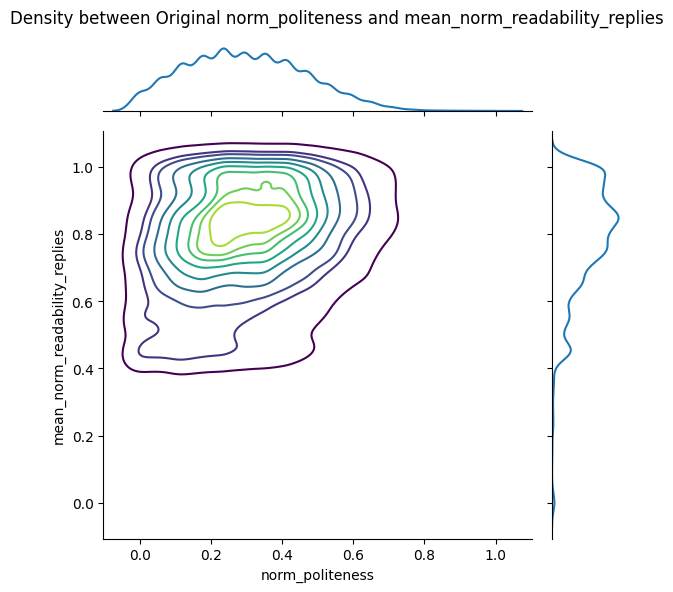

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.042
Model:                            WLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     574.2
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          3.30e-124
Time:                        06:43:40   Log-Likelihood:                 5153.6
No. Observations:               13025   AIC:                        -1.030e+04
Df Residuals:                   13023   BIC:                        -1.029e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

<Figure size 800x600 with 0 Axes>

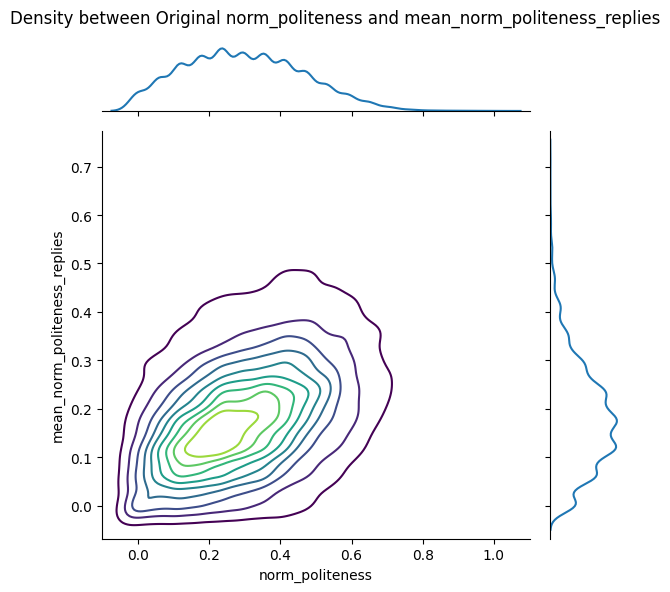

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.149
Model:                            WLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     2272.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:43:50   Log-Likelihood:                 5920.0
No. Observations:               13025   AIC:                        -1.184e+04
Df Residuals:                   13023   BIC:                        -1.182e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Figure size 800x600 with 0 Axes>

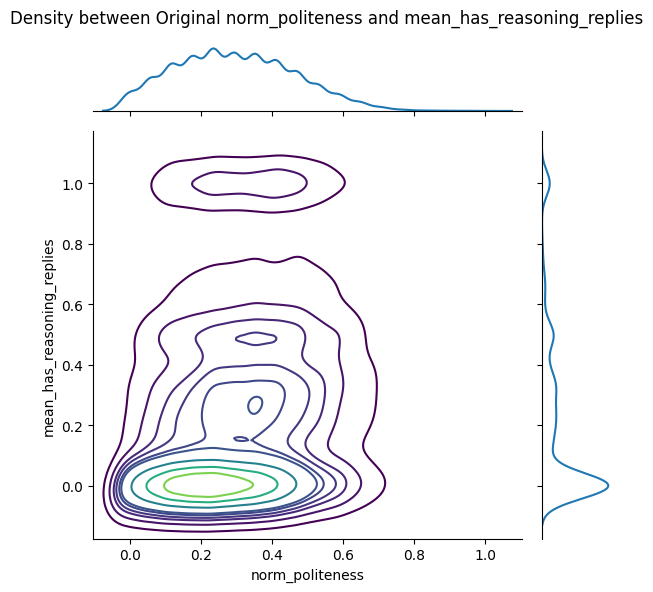

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.043
Model:                            WLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     580.5
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          1.62e-125
Time:                        06:44:00   Log-Likelihood:                 5156.6
No. Observations:               13025   AIC:                        -1.031e+04
Df Residuals:                   13023   BIC:                        -1.029e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

<Figure size 800x600 with 0 Axes>

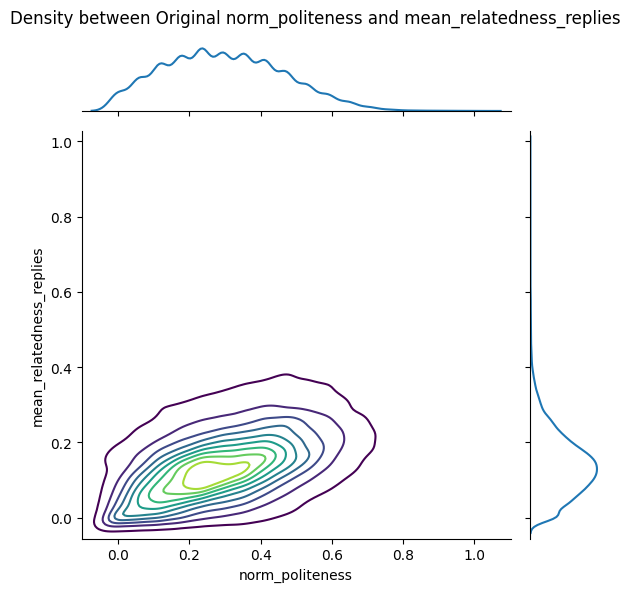

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.195
Model:                            WLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     3146.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:44:10   Log-Likelihood:                 6281.7
No. Observations:               13025   AIC:                        -1.256e+04
Df Residuals:                   13023   BIC:                        -1.254e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
lm_to_mean_replies(filter_posts(df), 'norm_politeness')

Pearson Correlation Coefficient:  0.18835454254910583
Breusch-Pagan Test for normality of residuals:
Test Statistic: 182.4094
P-value: 0.0000
Durbin-Watson Statistic: 1.6261
                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.035
Model:                            WLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     3117.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:44:23   Log-Likelihood:                 45055.
No. Observations:               84754   AIC:                        -9.011e+04
Df Residuals:                   84752   BIC:                        -9.009e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    

<Figure size 800x600 with 0 Axes>

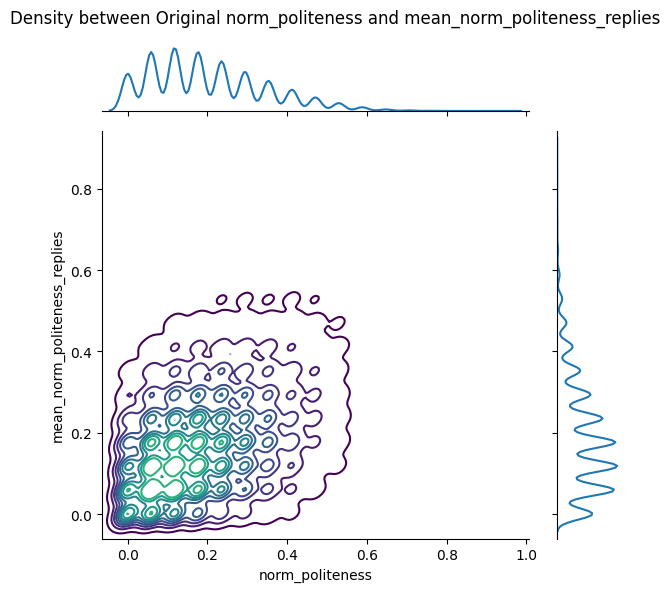

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.143
Model:                            WLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                 1.411e+04
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:44:23   Log-Likelihood:                 50051.
No. Observations:               84754   AIC:                        -1.001e+05
Df Residuals:                   84752   BIC:                        -1.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Figure size 800x600 with 0 Axes>

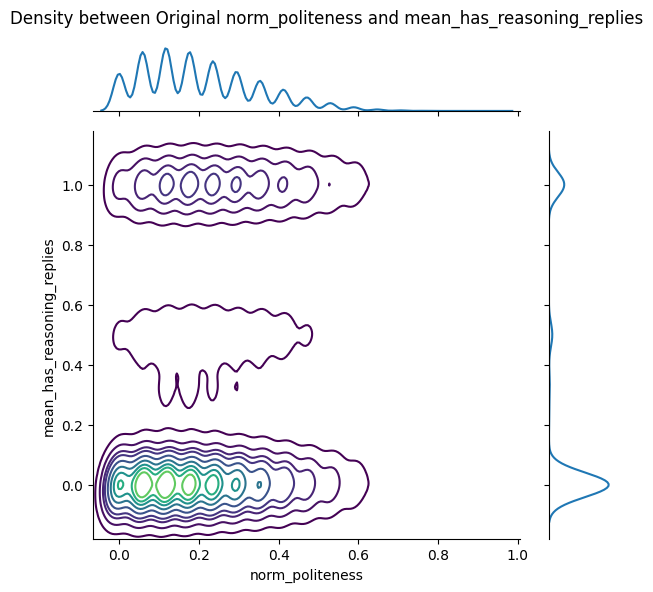

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.038
Model:                            WLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     3314.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:45:47   Log-Likelihood:                 45150.
No. Observations:               84754   AIC:                        -9.030e+04
Df Residuals:                   84752   BIC:                        -9.028e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

<Figure size 800x600 with 0 Axes>

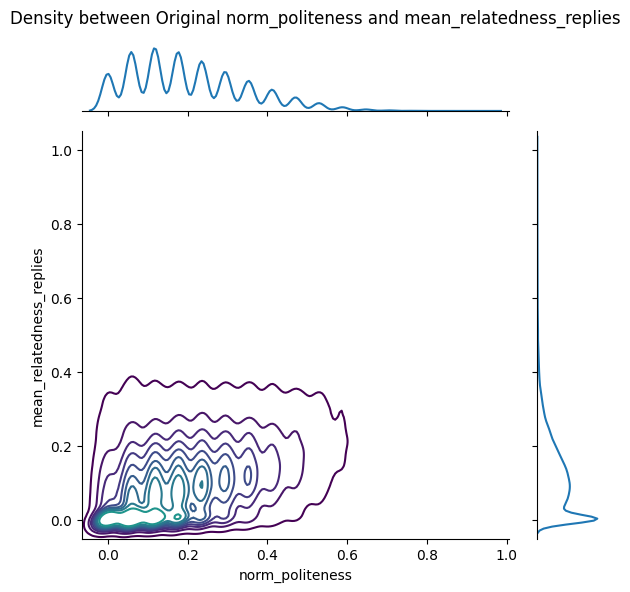

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.097
Model:                            WLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     9152.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:46:57   Log-Likelihood:                 47870.
No. Observations:               84754   AIC:                        -9.574e+04
Df Residuals:                   84752   BIC:                        -9.572e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
lm_to_mean_replies(filter_non_posts(df), 'norm_politeness')

Pearson Correlation Coefficient:  0.1863301148190054
Breusch-Pagan Test for normality of residuals:
Test Statistic: 185.0197
P-value: 0.0000
Durbin-Watson Statistic: 1.6613
                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.035
Model:                            WLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     3564.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:48:23   Log-Likelihood:                 48256.
No. Observations:               99082   AIC:                        -9.651e+04
Df Residuals:                   99080   BIC:                        -9.649e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    c

<Figure size 800x600 with 0 Axes>

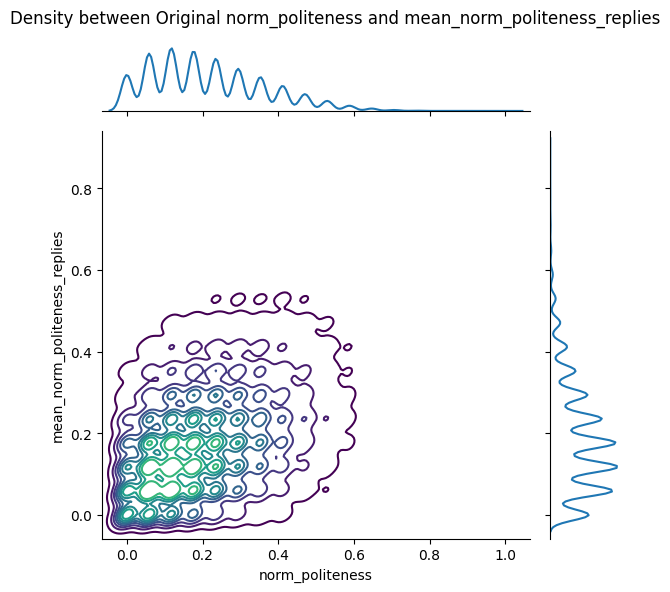

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.134
Model:                            WLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                 1.532e+04
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:48:23   Log-Likelihood:                 53629.
No. Observations:               99082   AIC:                        -1.073e+05
Df Residuals:                   99080   BIC:                        -1.072e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Figure size 800x600 with 0 Axes>

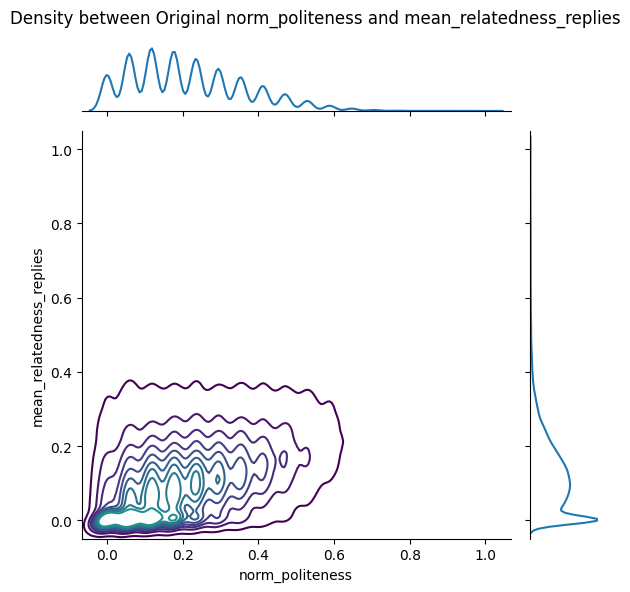

                            WLS Regression Results                            
Dep. Variable:        norm_politeness   R-squared:                       0.110
Model:                            WLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                 1.226e+04
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:50:02   Log-Likelihood:                 52284.
No. Observations:               99082   AIC:                        -1.046e+05
Df Residuals:                   99080   BIC:                        -1.045e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
lm_to_mean_replies(df, 'norm_politeness')

##Relatedness

Pearson Correlation Coefficient:  0.12312048304029846
Breusch-Pagan Test for normality of residuals:
Test Statistic: 3.1161
P-value: 0.0775
Durbin-Watson Statistic: 1.6098
                            OLS Regression Results                            
Dep. Variable:            relatedness   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1325.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          8.15e-288
Time:                        13:36:55   Log-Likelihood:                 64975.
No. Observations:               86057   AIC:                        -1.299e+05
Df Residuals:                   86055   BIC:                        -1.299e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    co

<Figure size 800x600 with 0 Axes>

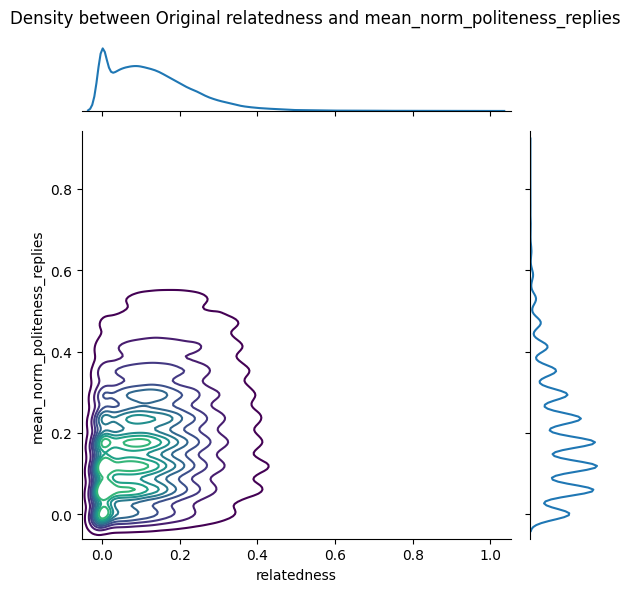

                            WLS Regression Results                            
Dep. Variable:            relatedness   R-squared:                       0.060
Model:                            WLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     5449.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:36:55   Log-Likelihood:                 66960.
No. Observations:               86057   AIC:                        -1.339e+05
Df Residuals:                   86055   BIC:                        -1.339e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Figure size 800x600 with 0 Axes>

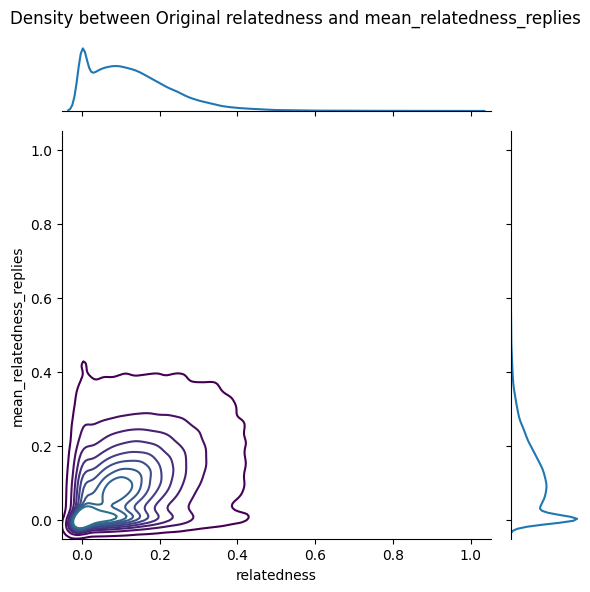

                            WLS Regression Results                            
Dep. Variable:            relatedness   R-squared:                       0.107
Model:                            WLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                 1.033e+04
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        13:38:23   Log-Likelihood:                 69196.
No. Observations:               86057   AIC:                        -1.384e+05
Df Residuals:                   86055   BIC:                        -1.384e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
lm_to_mean_replies(df, 'relatedness')

##Reasoning

for mean_norm_readability_replies


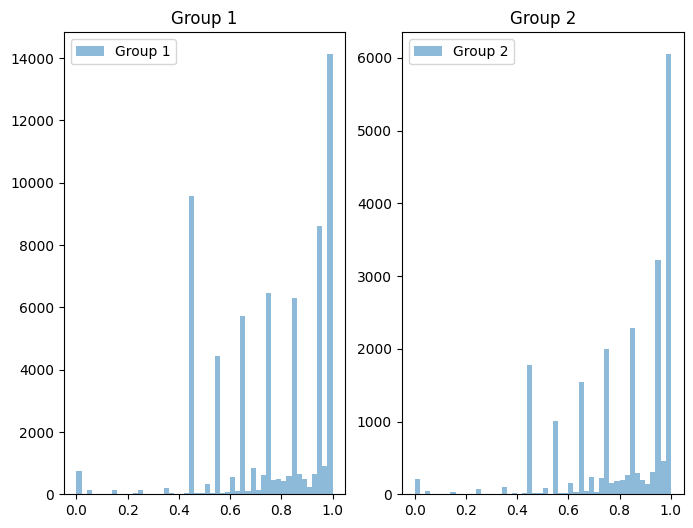

Group 1 normality statistic: 2317.7225
Group 1 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 2 normality statistic: 1112.4502
Group 2 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 1 skewness: -0.8101 kurtosis: 0.2174
Group 2 skewness: -1.2889 kurtosis: 1.5750
The data is normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 596838832.5
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.23446362993211645
for mean_norm_politeness_replies


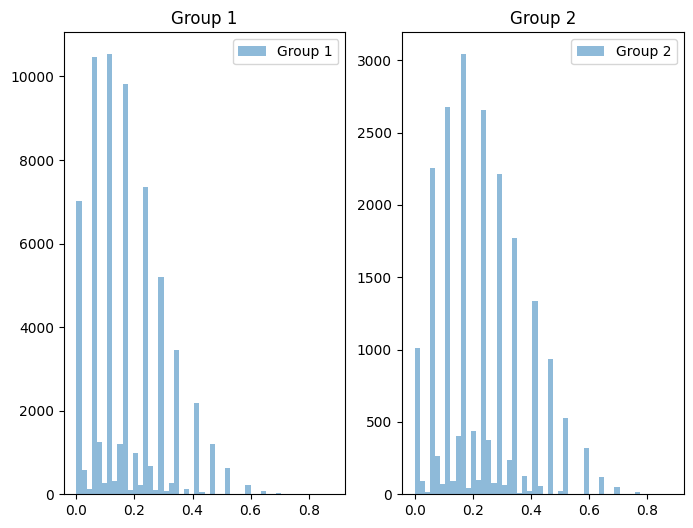

Group 1 normality statistic: 1107.3891
Group 1 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 2 normality statistic: 236.0611
Group 2 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 1 skewness: 0.7896 kurtosis: 0.3847
Group 2 skewness: 0.5840 kurtosis: -0.0474
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 519722972.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.46832311866680165
for mean_has_reasoning_replies


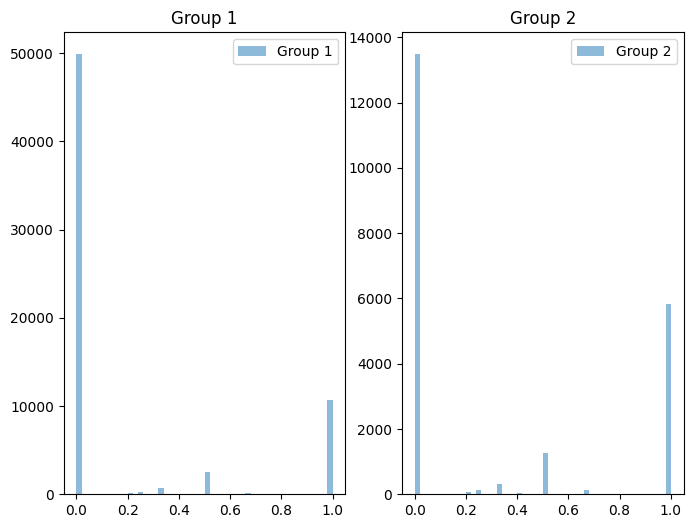

Group 1 normality statistic: 15309.7766
Group 1 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 2 normality statistic: 3626.1055
Group 2 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 1 skewness: 1.5658 kurtosis: 0.6104
Group 2 skewness: 0.7933 kurtosis: -1.2422
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 592733224.5
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.316750430450158
for mean_evidence_replies


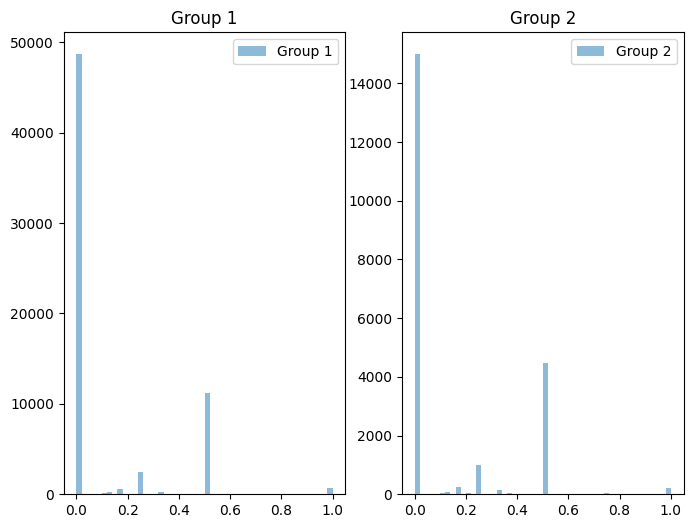

Group 1 normality statistic: 13858.3223
Group 1 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 2 normality statistic: 3999.6592
Group 2 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 1 skewness: 1.7513 kurtosis: 2.2611
Group 2 skewness: 1.3951 kurtosis: 0.9309
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 656144802.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.10336004991034627
for mean_relatedness_replies


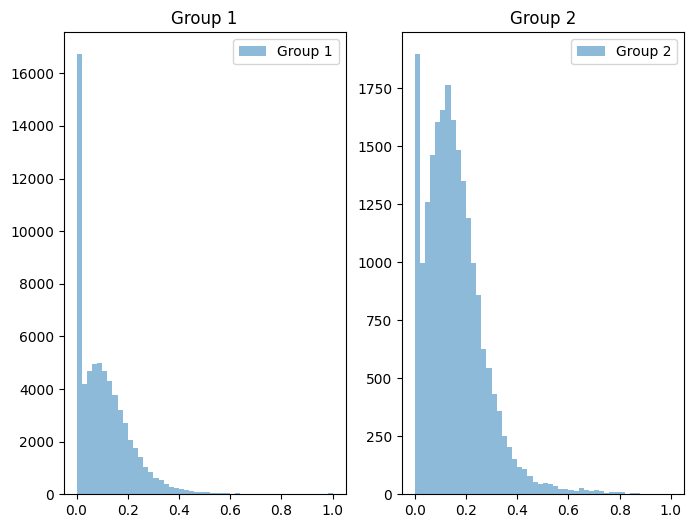

Group 1 normality statistic: 1896.3696
Group 1 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 2 normality statistic: 293.1154
Group 2 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 1 skewness: 1.9187 kurtosis: 7.1938
Group 2 skewness: 1.4831 kurtosis: 4.4021
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 489493976.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.4506944138854042


In [ ]:
two_sample_test_to_mean_replies(filter_non_posts(df), 'has_reasoning', 0, 1)

for mean_norm_readability_replies


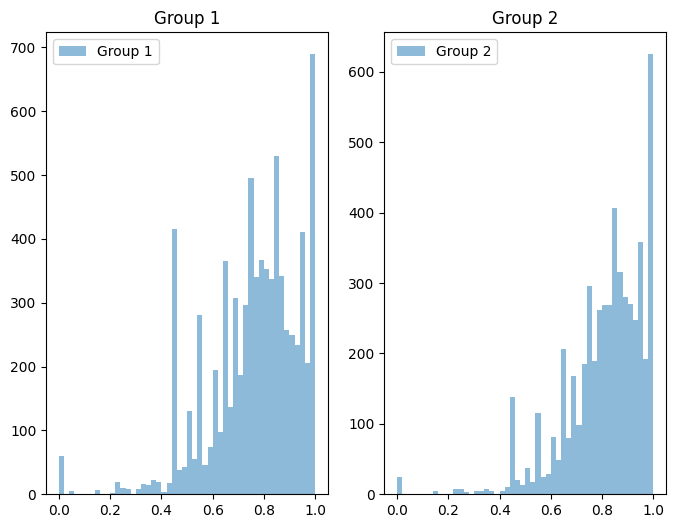

Group 1 normality statistic: 100.0345
Group 1 critical values: [0.576 0.656 0.787 0.918 1.091]
Group 2 normality statistic: 104.1371
Group 2 critical values: [0.576 0.656 0.786 0.917 1.091]
Group 1 skewness: -1.0607 kurtosis: 1.7920
Group 2 skewness: -1.4365 kurtosis: 3.4610
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 16995633.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.29181732806845856
for mean_norm_politeness_replies


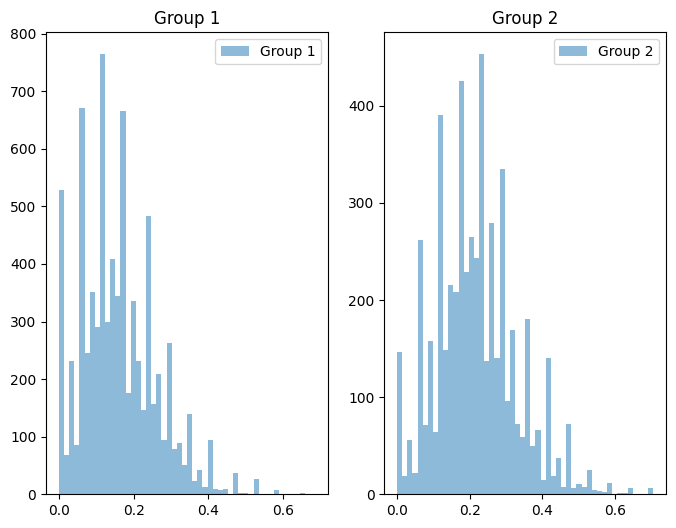

Group 1 normality statistic: 52.7116
Group 1 critical values: [0.576 0.656 0.787 0.918 1.091]
Group 2 normality statistic: 17.5354
Group 2 critical values: [0.576 0.656 0.786 0.917 1.091]
Group 1 skewness: 0.7422 kurtosis: 0.7900
Group 2 skewness: 0.5172 kurtosis: 0.5625
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 14145426.5
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.5423514439285929
for mean_has_reasoning_replies


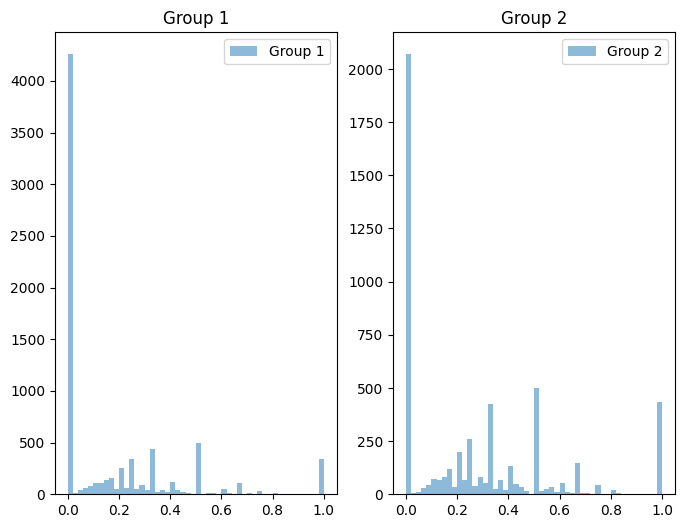

Group 1 normality statistic: 821.1155
Group 1 critical values: [0.576 0.656 0.787 0.918 1.091]
Group 2 normality statistic: 289.9345
Group 2 critical values: [0.576 0.656 0.786 0.917 1.091]
Group 1 skewness: 1.7218 kurtosis: 2.5064
Group 2 skewness: 1.0491 kurtosis: 0.2559
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 16275018.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.36344523299901144
for mean_evidence_replies


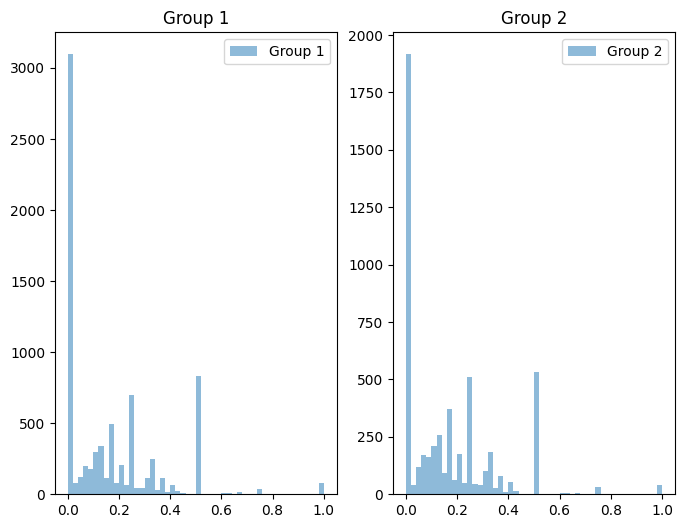

Group 1 normality statistic: 466.7683
Group 1 critical values: [0.576 0.656 0.787 0.918 1.091]
Group 2 normality statistic: 262.9304
Group 2 critical values: [0.576 0.656 0.786 0.917 1.091]
Group 1 skewness: 1.4291 kurtosis: 2.3191
Group 2 skewness: 1.3751 kurtosis: 2.3120
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 19931405.0
p-value: 0.0046
The groups have significantly different distributions.
Cohen's d: -0.015310853977559689
for mean_relatedness_replies


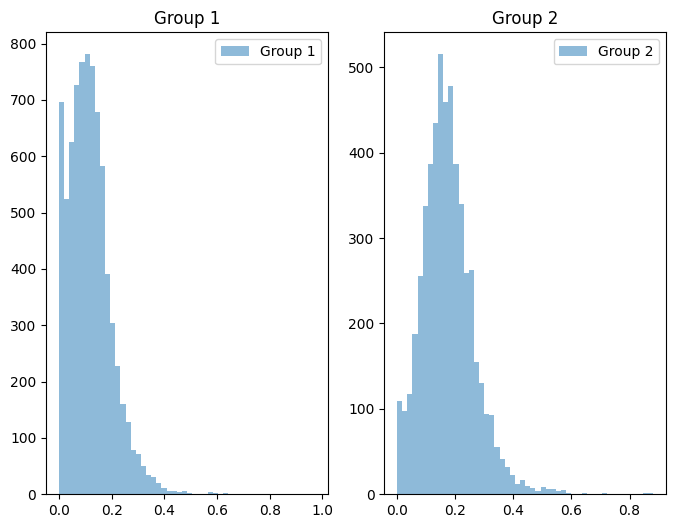

Group 1 normality statistic: 69.9011
Group 1 critical values: [0.576 0.656 0.787 0.918 1.091]
Group 2 normality statistic: 30.0128
Group 2 critical values: [0.576 0.656 0.786 0.917 1.091]
Group 1 skewness: 1.4725 kurtosis: 6.6977
Group 2 skewness: 0.9996 kurtosis: 3.1628
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 12449445.5
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.6609894297437268


In [ ]:
two_sample_test_to_mean_replies(filter_posts(df), 'has_reasoning', 0, 1)

for mean_norm_readability_replies


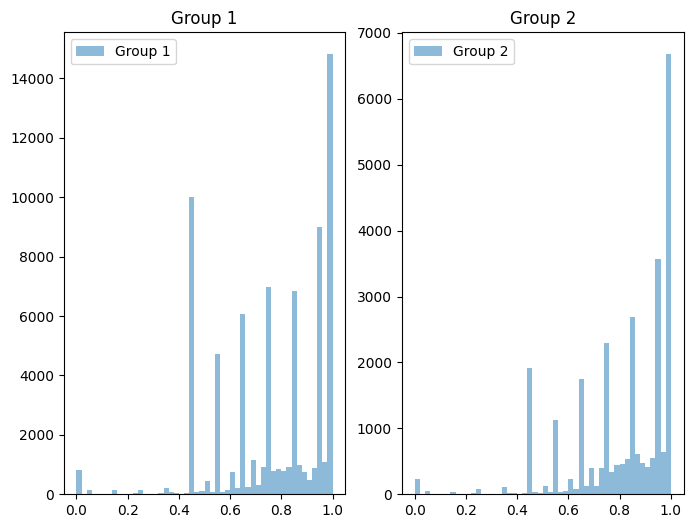

Group 1 normality statistic: 2300.5479
Group 1 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 2 normality statistic: 1146.8918
Group 2 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 1 skewness: -0.8276 kurtosis: 0.3329
Group 2 skewness: -1.3160 kurtosis: 1.8685
The data is normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 838824325.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.23815658928428632
for mean_norm_politeness_replies


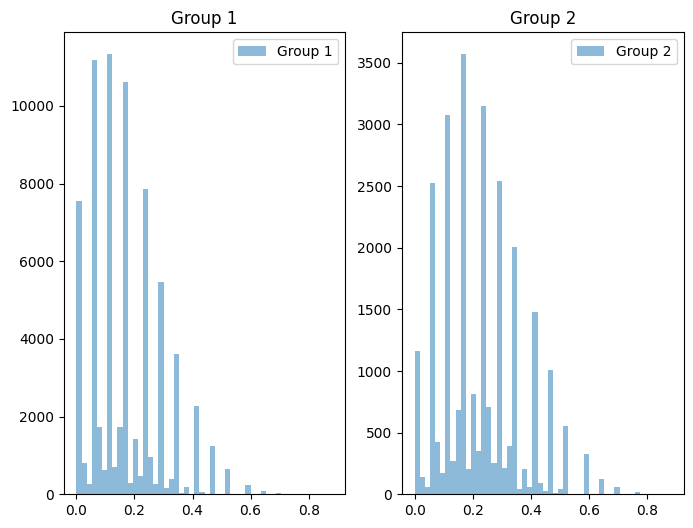

Group 1 normality statistic: 1157.2344
Group 1 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 2 normality statistic: 252.2774
Group 2 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 1 skewness: 0.7994 kurtosis: 0.4588
Group 2 skewness: 0.6063 kurtosis: 0.1193
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 721281838.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.4641970816483793
for mean_has_reasoning_replies


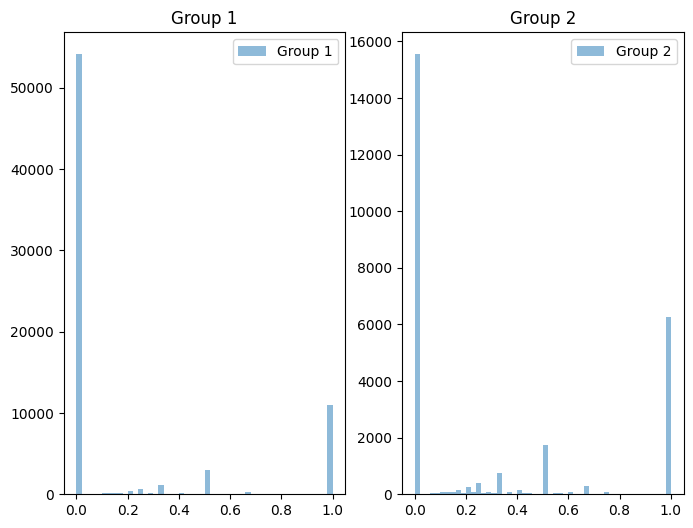

Group 1 normality statistic: 16091.7070
Group 1 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 2 normality statistic: 3812.7311
Group 2 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 1 skewness: 1.5990 kurtosis: 0.7907
Group 2 skewness: 0.8582 kurtosis: -1.0253
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 809558292.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.310150652697555
for mean_evidence_replies


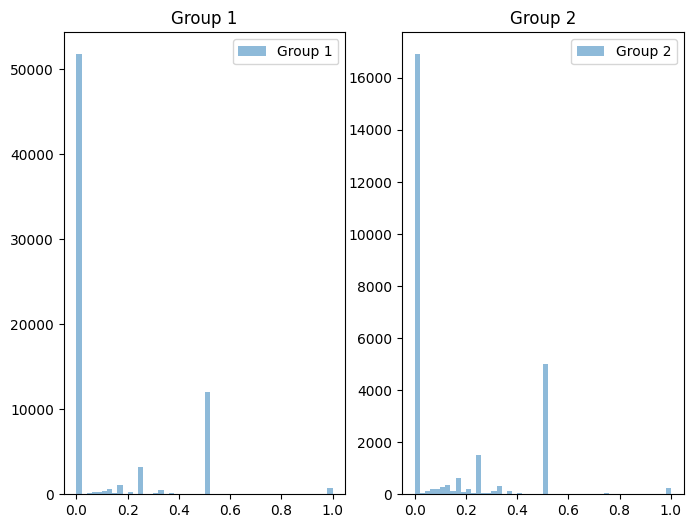

Group 1 normality statistic: 13901.5286
Group 1 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 2 normality statistic: 4032.7264
Group 2 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 1 skewness: 1.7007 kurtosis: 2.1867
Group 2 skewness: 1.3708 kurtosis: 1.0732
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 895548076.0
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.1092141507368404
for mean_relatedness_replies


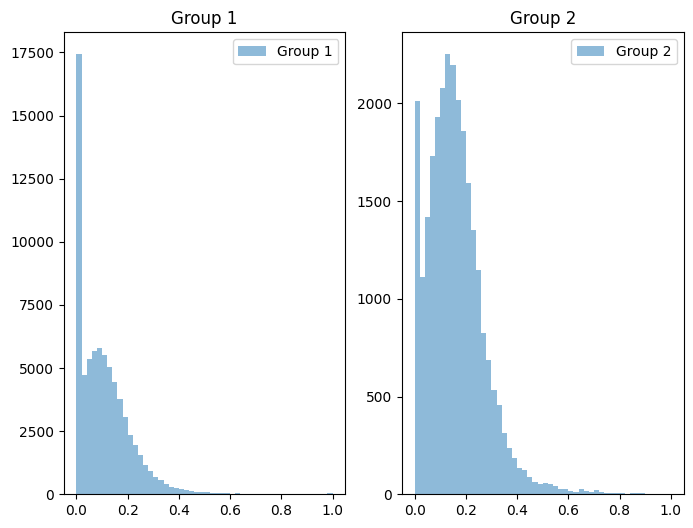

Group 1 normality statistic: 1893.2415
Group 1 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 2 normality statistic: 296.0894
Group 2 critical values: [0.576 0.656 0.787 0.918 1.092]
Group 1 skewness: 1.8963 kurtosis: 7.3059
Group 2 skewness: 1.4140 kurtosis: 4.4014
The data is not normally distributed by Skewness-Kurtosis All Normality Test.
The data is not normally distributed by Anderson Darling normality Test.
Mann-Whitney U-test statistic: 663316242.5
p-value: 0.0000
The groups have significantly different distributions.
Cohen's d: -0.48356254190670295


In [ ]:
two_sample_test_to_mean_replies(df, 'has_reasoning', 0, 1)

In [ ]:
lm_to_mean_replies(df, 'has_reasoning_one_shot')

Breusch-Pagan Test:
Test Statistic: 41.2954
P-value: 0.0000
Durbin-Watson Statistic: 1.8204
                              WLS Regression Results                              
Dep. Variable:     has_reasoning_one_shot   R-squared:                       0.003
Model:                                WLS   Adj. R-squared:                  0.003
Method:                     Least Squares   F-statistic:                     340.2
Date:                    Sat, 22 Jun 2024   Prob (F-statistic):           7.79e-76
Time:                            10:43:30   Log-Likelihood:                 4881.4
No. Observations:                   99082   AIC:                            -9759.
Df Residuals:                       99080   BIC:                            -9740.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                    coef    std err          t      P>|t|     

##Evidence

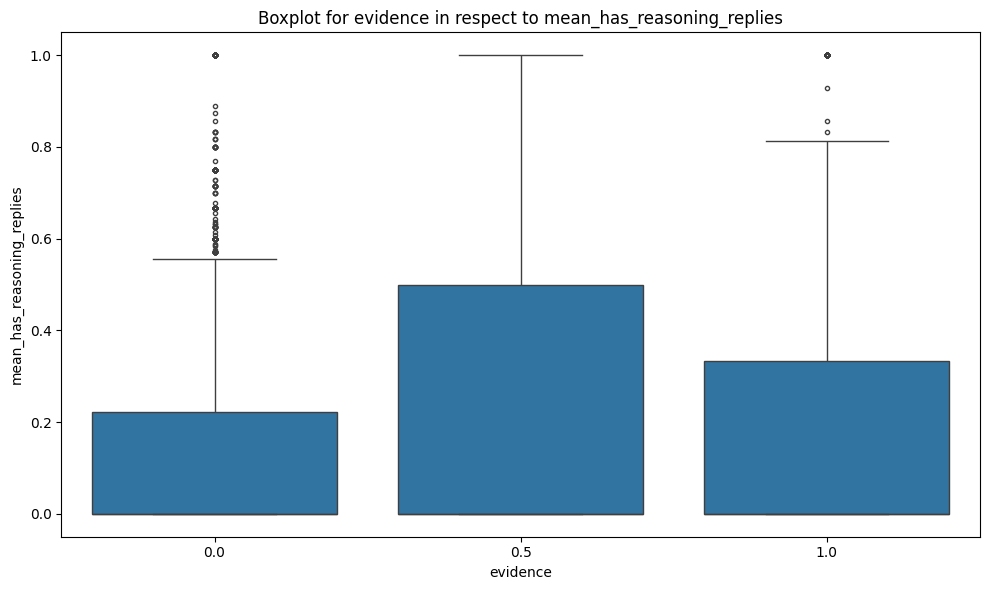

In [64]:
boxplots_for_categorical_to_numerical(df, 'evidence', 'mean_has_reasoning_replies')

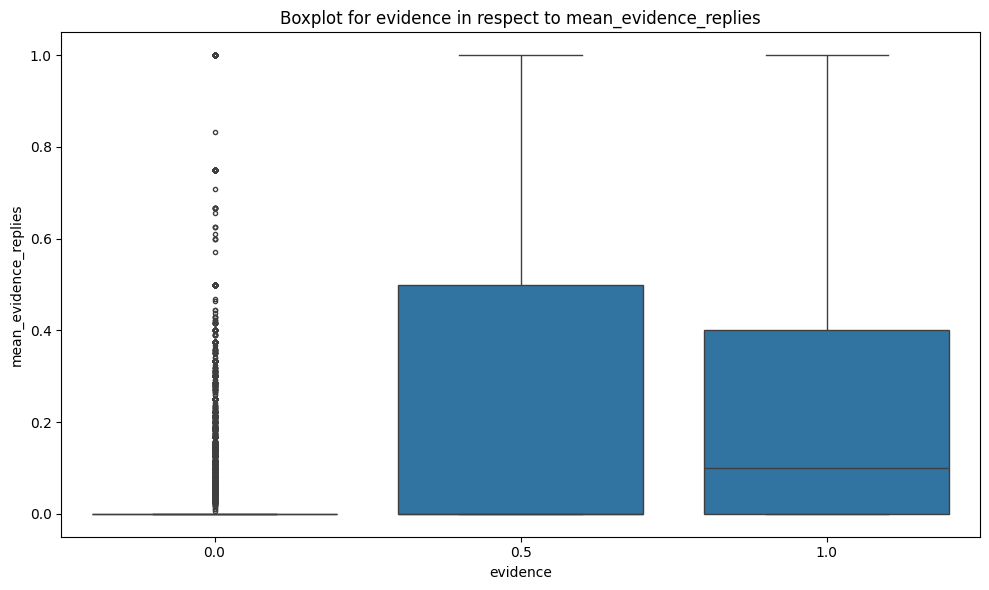

In [62]:
boxplots_for_categorical_to_numerical(df, 'evidence', 'mean_evidence_replies')

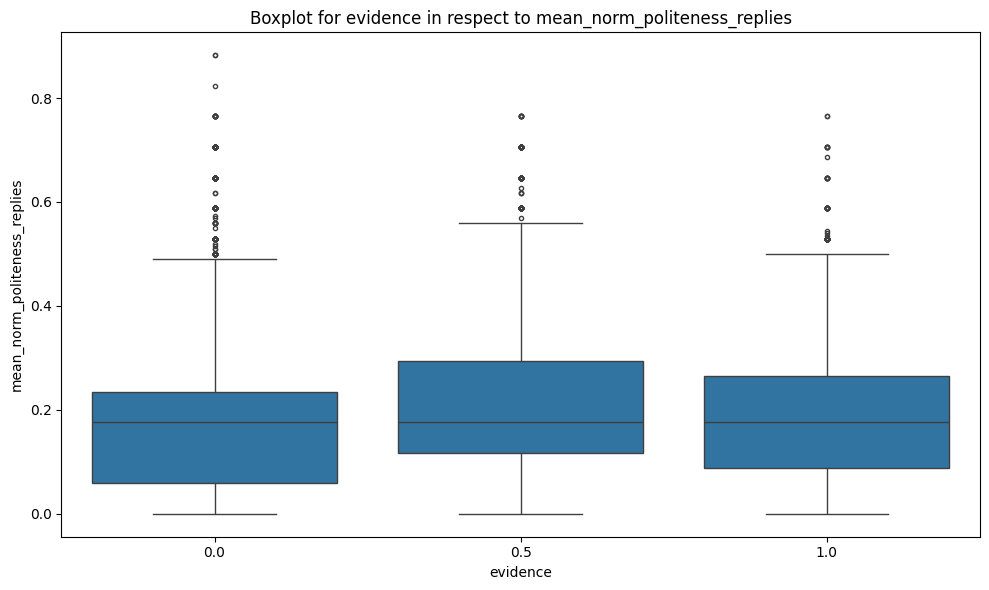

In [63]:
boxplots_for_categorical_to_numerical(df, 'evidence', 'mean_norm_politeness_replies')

##Length title

In [ ]:
lm_to_mean_replies(filter_posts(df), 'len_title')

Pearson Correlation Coefficient:  -0.0007307873021786791
Breusch-Pagan Test for normality of residuals:
Test Statistic: 4.0520
P-value: 0.0441
Durbin-Watson Statistic: 2.0058
                            WLS Regression Results                            
Dep. Variable:              len_title   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                  0.006955
Date:                Sun, 23 Jun 2024   Prob (F-statistic):              0.934
Time:                        06:52:20   Log-Likelihood:                -63280.
No. Observations:               13025   AIC:                         1.266e+05
Df Residuals:                   13023   BIC:                         1.266e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   

##Text length

In [ ]:
threshold = df['len_text'].quantile(0.99)
threshold

1835.0

In [ ]:
non_post_outlier_threshold = filter_non_posts(df)['len_text'].quantile(0.99)
non_post_outlier_threshold

1557.0

In [ ]:
post_outlier_threshold = filter_posts(df)['len_text'].quantile(0.95)
post_outlier_threshold

2095.399999999994

Pearson Correlation Coefficient:  0.155286568915878
Breusch-Pagan Test for normality of residuals:
Test Statistic: 22.1803
P-value: 0.0000
Durbin-Watson Statistic: 1.9792
                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.024
Model:                            WLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     305.7
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           1.25e-67
Time:                        07:01:57   Log-Likelihood:                -91919.
No. Observations:               12372   AIC:                         1.838e+05
Df Residuals:                   12370   BIC:                         1.839e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    coe

<Figure size 800x600 with 0 Axes>

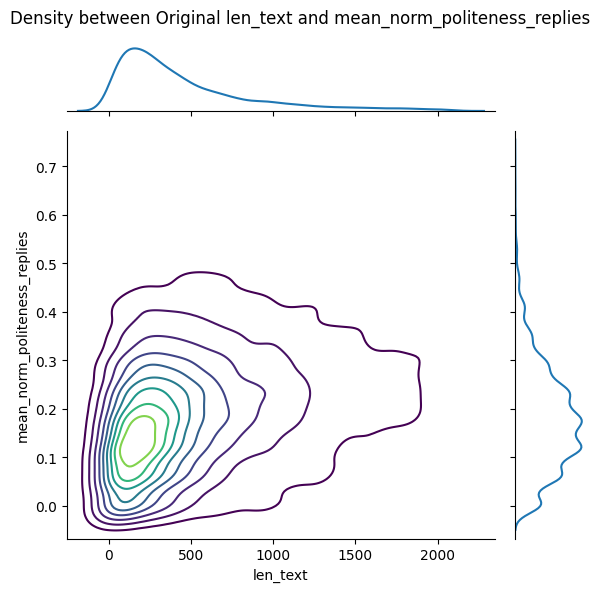

                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.103
Model:                            WLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     1413.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):          5.35e-293
Time:                        07:01:58   Log-Likelihood:                -91400.
No. Observations:               12372   AIC:                         1.828e+05
Df Residuals:                   12370   BIC:                         1.828e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Figure size 800x600 with 0 Axes>

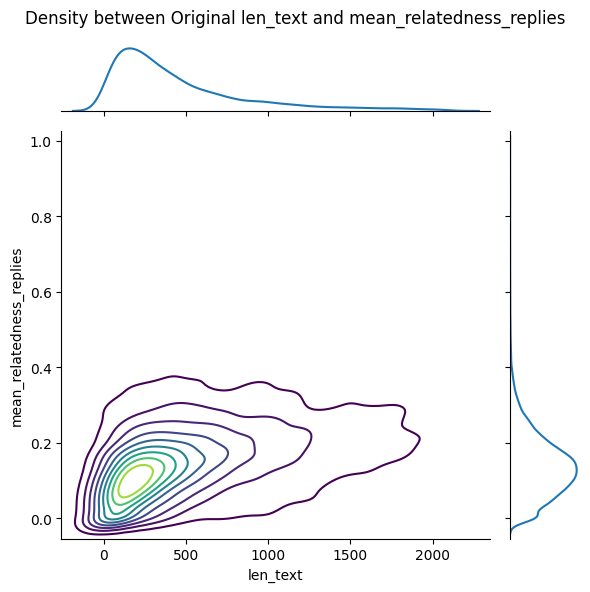

                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.173
Model:                            WLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     2589.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        07:02:06   Log-Likelihood:                -90894.
No. Observations:               12372   AIC:                         1.818e+05
Df Residuals:                   12370   BIC:                         1.818e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
lm_to_mean_replies(filter_posts(df[df['len_text'] < post_outlier_threshold]), 'len_text')

Pearson Correlation Coefficient:  0.16358574218361566
Breusch-Pagan Test for normality of residuals:
Test Statistic: 267.5176
P-value: 0.0000
Durbin-Watson Statistic: 1.6513
                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.027
Model:                            WLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     2299.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        07:09:22   Log-Likelihood:            -5.7688e+05
No. Observations:               83619   AIC:                         1.154e+06
Df Residuals:                   83617   BIC:                         1.154e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    

<Figure size 800x600 with 0 Axes>

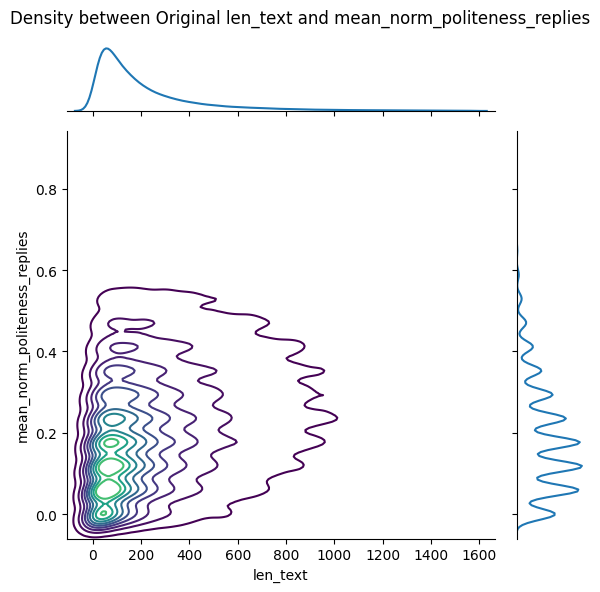

                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.110
Model:                            WLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                 1.034e+04
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        07:09:22   Log-Likelihood:            -5.7314e+05
No. Observations:               83619   AIC:                         1.146e+06
Df Residuals:                   83617   BIC:                         1.146e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Figure size 800x600 with 0 Axes>

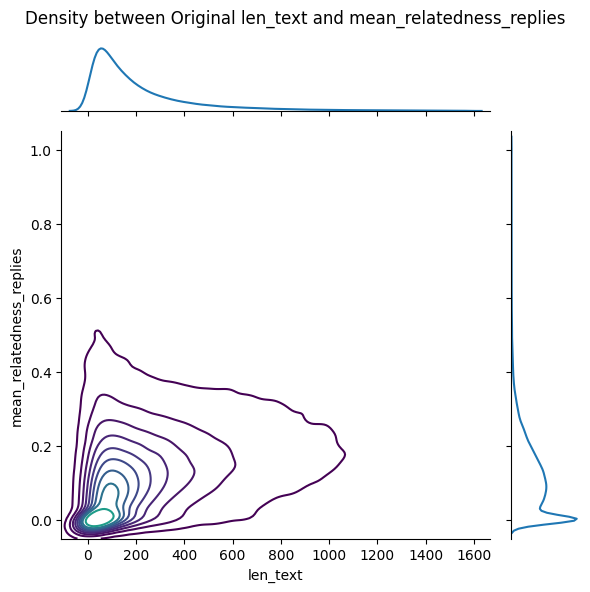

                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.114
Model:                            WLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                 1.071e+04
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        07:10:49   Log-Likelihood:            -5.7297e+05
No. Observations:               83619   AIC:                         1.146e+06
Df Residuals:                   83617   BIC:                         1.146e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
lm_to_mean_replies(filter_non_posts(df[df['len_text'] < non_post_outlier_threshold]), 'len_text')

Pearson Correlation Coefficient:  0.1536657148022552
Breusch-Pagan Test for normality of residuals:
Test Statistic: 303.1393
P-value: 0.0000
Durbin-Watson Statistic: 1.7030
                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.024
Model:                            WLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2358.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        07:14:39   Log-Likelihood:            -6.8894e+05
No. Observations:               97496   AIC:                         1.378e+06
Df Residuals:                   97494   BIC:                         1.378e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    c

<Figure size 800x600 with 0 Axes>

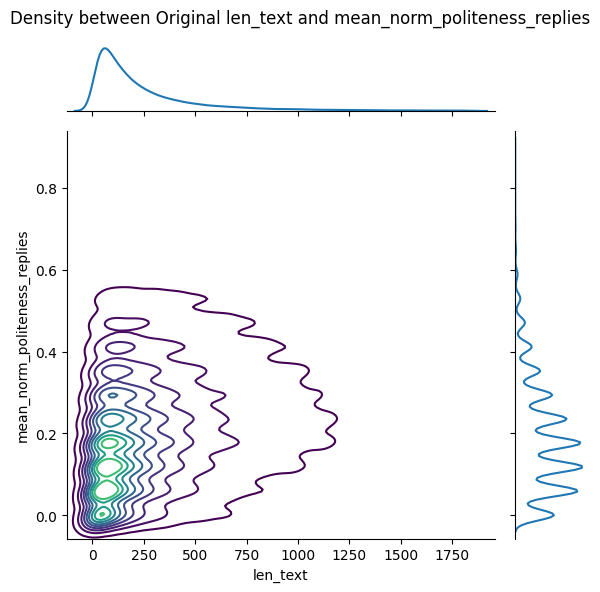

                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.096
Model:                            WLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                 1.034e+04
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        07:14:39   Log-Likelihood:            -6.8520e+05
No. Observations:               97496   AIC:                         1.370e+06
Df Residuals:                   97494   BIC:                         1.370e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

<Figure size 800x600 with 0 Axes>

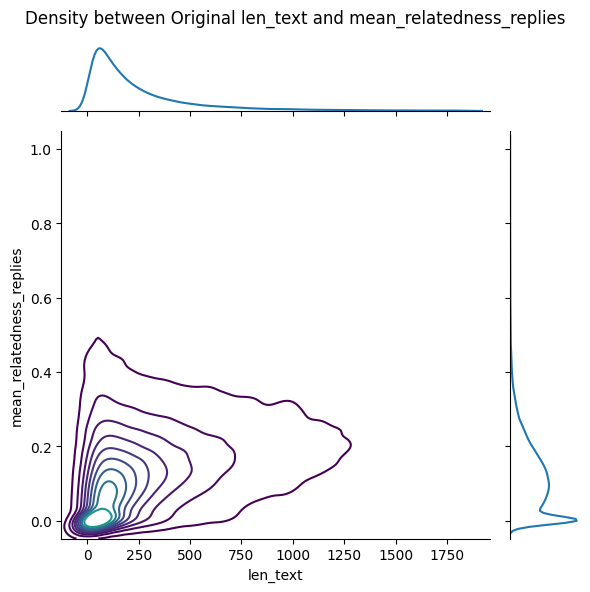

                            WLS Regression Results                            
Dep. Variable:               len_text   R-squared:                       0.120
Model:                            WLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                 1.326e+04
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        07:16:21   Log-Likelihood:            -6.8389e+05
No. Observations:               97496   AIC:                         1.368e+06
Df Residuals:                   97494   BIC:                         1.368e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [ ]:
lm_to_mean_replies(df[df['len_text'] < threshold], 'len_text')

##Readability

In [ ]:
lm_to_mean_replies(filter_posts(df), 'norm_readability')

Pearson Correlation Coefficient:  0.09795315242711213
Breusch-Pagan Test for normality of residuals:
Test Statistic: 37.1488
P-value: 0.0000
Durbin-Watson Statistic: 1.9918
                            WLS Regression Results                            
Dep. Variable:       norm_readability   R-squared:                       0.010
Model:                            WLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     126.2
Date:                Sun, 23 Jun 2024   Prob (F-statistic):           3.85e-29
Time:                        06:56:54   Log-Likelihood:                 1430.3
No. Observations:               13025   AIC:                            -2857.
Df Residuals:                   13023   BIC:                            -2842.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    c

In [ ]:
lm_to_mean_replies(filter_non_posts(df), 'norm_readability')

Pearson Correlation Coefficient:  0.14801258764760825
Breusch-Pagan Test for normality of residuals:
Test Statistic: 318.6842
P-value: 0.0000
Durbin-Watson Statistic: 1.9026
                            WLS Regression Results                            
Dep. Variable:       norm_readability   R-squared:                       0.022
Model:                            WLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1898.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:56:55   Log-Likelihood:                 9380.7
No. Observations:               84754   AIC:                        -1.876e+04
Df Residuals:                   84752   BIC:                        -1.874e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    

In [ ]:
lm_to_mean_replies(df, 'norm_readability')

Pearson Correlation Coefficient:  0.1428645362593667
Breusch-Pagan Test for normality of residuals:
Test Statistic: 361.7973
P-value: 0.0000
Durbin-Watson Statistic: 1.9230
                            WLS Regression Results                            
Dep. Variable:       norm_readability   R-squared:                       0.020
Model:                            WLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2064.
Date:                Sun, 23 Jun 2024   Prob (F-statistic):               0.00
Time:                        06:56:55   Log-Likelihood:                 10578.
No. Observations:               99082   AIC:                        -2.115e+04
Df Residuals:                   99080   BIC:                        -2.113e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                    c

##Subreddit subscribers

In [ ]:
lm_to_maxims(df, 'comments_count_conv')

Pearson Correlation Coefficient:  -0.019390655349948722
Breusch-Pagan Test for normality of residuals:
Test Statistic: 2.7918
P-value: 0.0947
Durbin-Watson Statistic: 1.9586
                             OLS Regression Results                            
Dep. Variable:     comments_count_conv   R-squared:                       0.000
Model:                             OLS   Adj. R-squared:                  0.000
Method:                  Least Squares   F-statistic:                     4.905
Date:                 Sun, 23 Jun 2024   Prob (F-statistic):             0.0268
Time:                         14:11:20   Log-Likelihood:                -68408.
No. Observations:                13043   AIC:                         1.368e+05
Df Residuals:                    13041   BIC:                         1.368e+05
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coe

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
lm_to_maxims(df, 'log_subreddit_subscribers')

Pearson Correlation Coefficient:  0.027556276303164387
Breusch-Pagan Test for normality of residuals:
Test Statistic: 34.9165
P-value: 0.0000
Durbin-Watson Statistic: 0.1327
                                WLS Regression Results                               
Dep. Variable:     log_subreddit_subscribers   R-squared:                       0.001
Model:                                   WLS   Adj. R-squared:                  0.001
Method:                        Least Squares   F-statistic:                     165.1
Date:                       Sun, 23 Jun 2024   Prob (F-statistic):           9.03e-38
Time:                               07:30:01   Log-Likelihood:            -4.8118e+05
No. Observations:                     217245   AIC:                         9.624e+05
Df Residuals:                         217243   BIC:                         9.624e+05
Df Model:                                  1                                         
Covariance Type:                   nonrobust        

##Subreddit topic

In [ ]:
df['topic'].value_counts()

topic
unknown          129856
media             29251
sport             12715
personal          10284
demographic        8229
health             7066
entertainment      5202
hobby              4185
finance            3705
religion           1508
politic            1469
gaming              673
education           547
tech                539
society             535
food                435
career              398
travel              246
music               244
psychology          145
sharing              83
news                 82
Name: count, dtype: int64

            topic  mean_norm_readability_conv
0       education                    0.877090
1          career                    0.848572
2         society                    0.829588
3          health                    0.827753
4         politic                    0.821049
5        personal                    0.791497
6          gaming                    0.791383
7           music                    0.787212
8         finance                    0.780115
9            tech                    0.778518
10     psychology                    0.775973
11          media                    0.775513
12       religion                    0.773723
13          sport                    0.770210
14        unknown                    0.769283
15           food                    0.755566
16         travel                    0.751475
17  entertainment                    0.731499
18           news                    0.723474
19          hobby                    0.719346
20    demographic                 

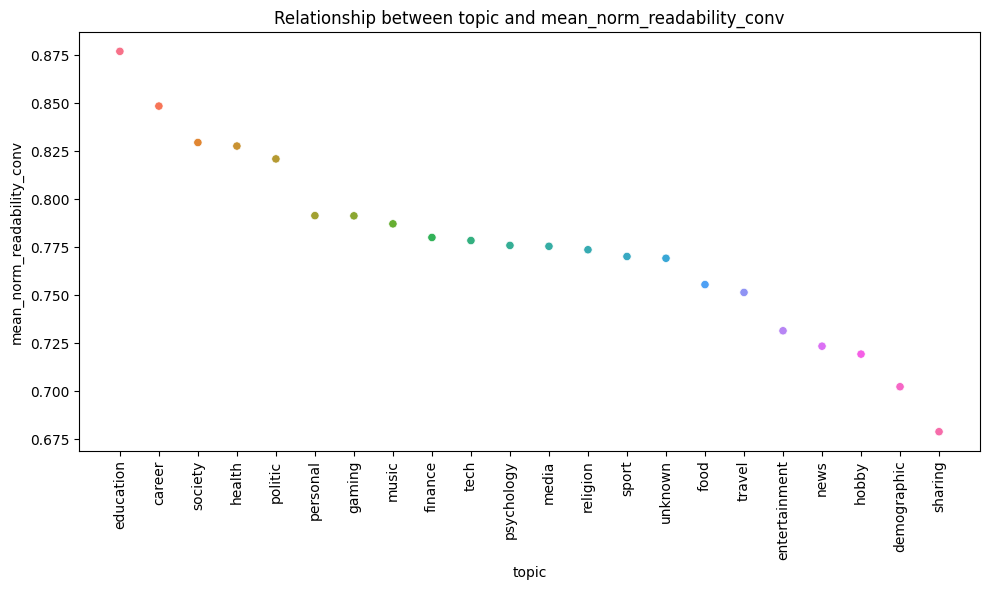

            topic  mean_norm_politeness_conv
0          health                   0.269559
1       education                   0.255178
2         politic                   0.238387
3         society                   0.237607
4        personal                   0.219823
5        religion                   0.208244
6         finance                   0.185494
7         unknown                   0.181511
8           media                   0.168030
9           music                   0.167315
10           food                   0.166352
11         career                   0.165104
12         gaming                   0.164312
13           news                   0.157903
14     psychology                   0.150916
15         travel                   0.150240
16          sport                   0.143849
17  entertainment                   0.142527
18          hobby                   0.140994
19           tech                   0.134350
20    demographic                   0.133534
21        

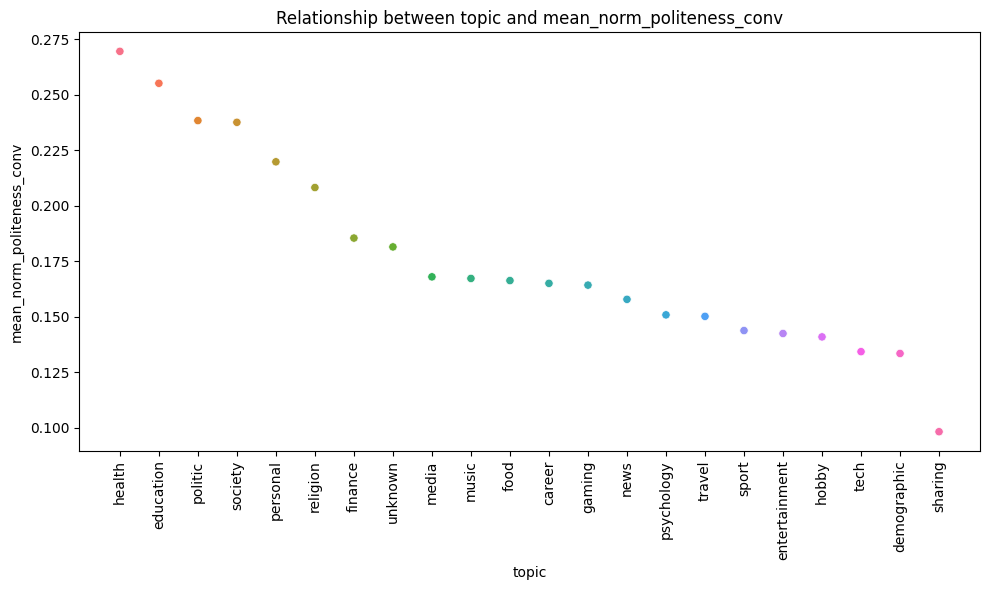

            topic  mean_has_reasoning_conv
0          health                 0.349348
1         society                 0.320225
2       education                 0.306773
3        personal                 0.261868
4          career                 0.261097
5        religion                 0.245176
6         politic                 0.244982
7         finance                 0.236538
8           media                 0.214978
9         unknown                 0.209109
10         gaming                 0.204274
11           food                 0.182876
12  entertainment                 0.163586
13          music                 0.153696
14           tech                 0.152441
15          sport                 0.145493
16    demographic                 0.136468
17          hobby                 0.126413
18         travel                 0.125123
19     psychology                 0.119623
20           news                 0.067345
21        sharing                 0.000000


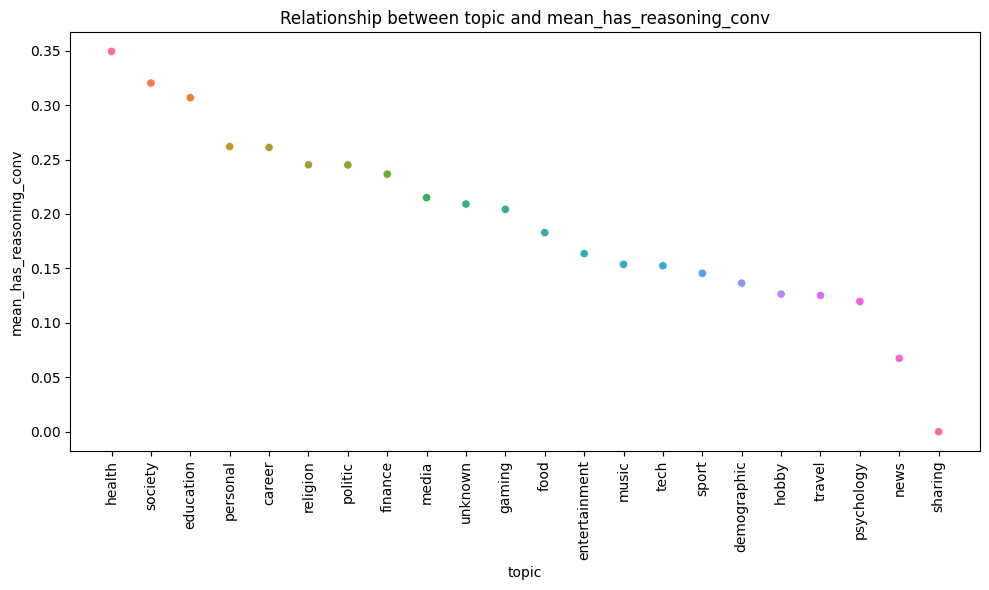

            topic  mean_evidence_conv
0          travel            0.242380
1            tech            0.207134
2         finance            0.186523
3           hobby            0.157151
4         society            0.152622
5            food            0.152365
6         unknown            0.148069
7            news            0.146923
8           media            0.141613
9           sport            0.140455
10  entertainment            0.133522
11         gaming            0.131757
12         health            0.121809
13      education            0.111284
14         career            0.105561
15        politic            0.104468
16       personal            0.102521
17       religion            0.090917
18          music            0.085108
19    demographic            0.084282
20        sharing            0.054258
21     psychology            0.028257


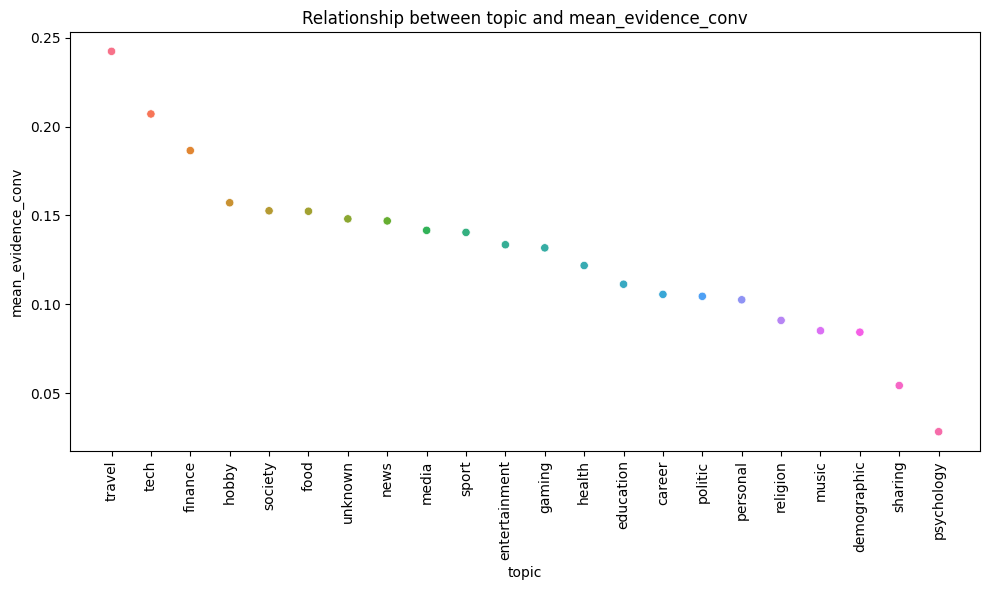

            topic  mean_relatedness_conv
0       education               0.167310
1         politic               0.166946
2      psychology               0.166759
3           music               0.166294
4          career               0.161614
5          health               0.158711
6        personal               0.153291
7        religion               0.152159
8         finance               0.140819
9            food               0.133048
10        unknown               0.130643
11          media               0.124700
12           tech               0.119097
13        society               0.116847
14          hobby               0.110616
15         gaming               0.109888
16  entertainment               0.107992
17         travel               0.105327
18           news               0.104239
19    demographic               0.097871
20          sport               0.097238
21        sharing               0.047118


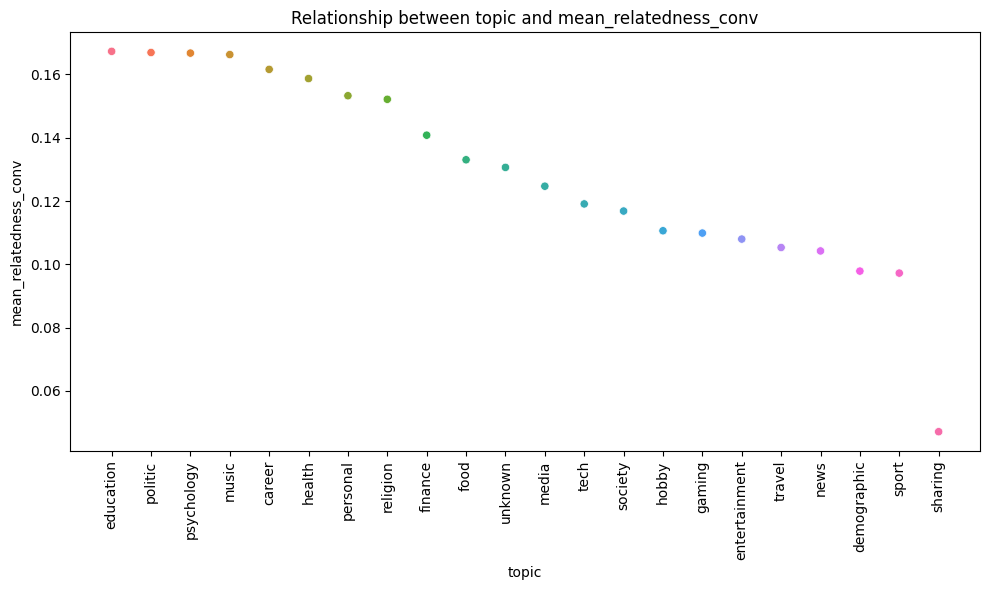

In [ ]:
for m in maxim_mean_over_conversations:
  scatter_with_categorical(df, 'topic', m)

            topic  norm_readability
0       education          0.856124
1          travel          0.844919
2          career          0.832035
3         society          0.829813
4        religion          0.828183
5         politic          0.827093
6          gaming          0.819762
7        personal          0.805261
8         finance          0.802848
9          health          0.800474
10          media          0.791366
11        unknown          0.788754
12           tech          0.775603
13           food          0.775172
14     psychology          0.769310
15          sport          0.766017
16  entertainment          0.766013
17          music          0.757582
18    demographic          0.757376
19          hobby          0.745293
20           news          0.718293
21        sharing          0.649398


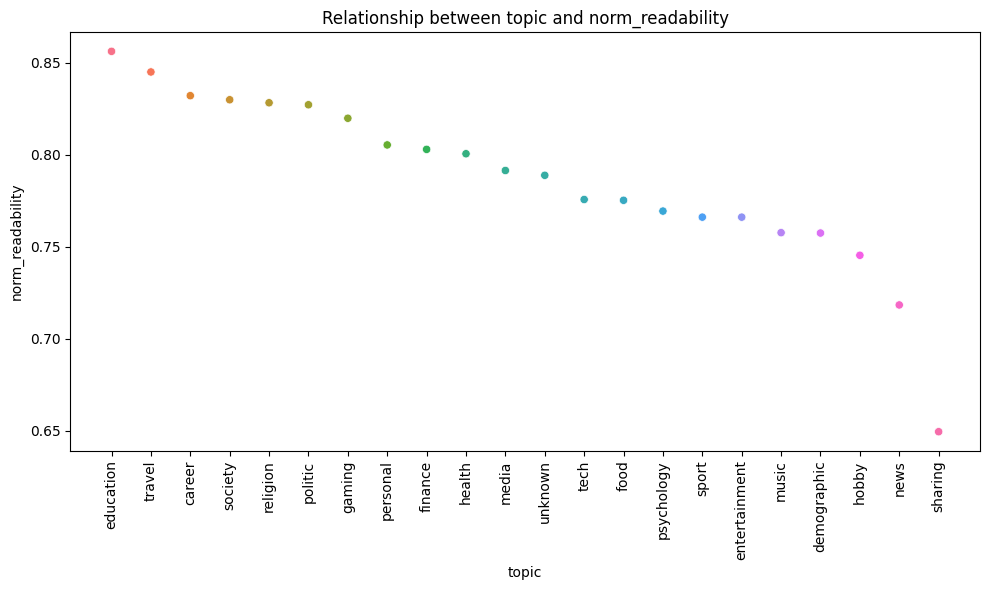

            topic  norm_politeness
0         politic         0.239058
1         society         0.237603
2          health         0.236634
3        religion         0.234241
4        personal         0.233063
5       education         0.232283
6            tech         0.220124
7          gaming         0.201294
8         unknown         0.196109
9          career         0.193763
10        finance         0.185298
11          media         0.184685
12         travel         0.183644
13           food         0.176471
14          hobby         0.170904
15     psychology         0.165112
16  entertainment         0.165072
17    demographic         0.160994
18          music         0.154773
19           news         0.149928
20          sport         0.134621
21        sharing         0.097803


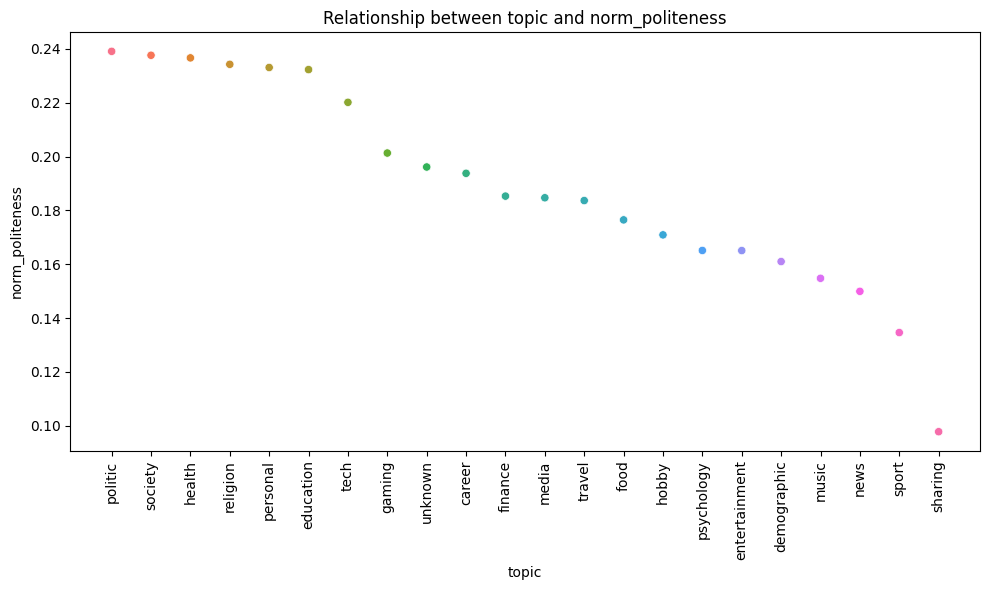

            topic  has_reasoning
0         politic       0.334241
1         society       0.319626
2       education       0.312614
3          health       0.294226
4        religion       0.291777
5        personal       0.285200
6          gaming       0.257058
7          career       0.256281
8           media       0.243205
9            tech       0.243043
10        unknown       0.238079
11        finance       0.219703
12     psychology       0.213793
13         travel       0.191057
14           food       0.188506
15          hobby       0.184229
16  entertainment       0.183775
17    demographic       0.176449
18          music       0.143443
19          sport       0.135902
20           news       0.109756
21        sharing       0.012048


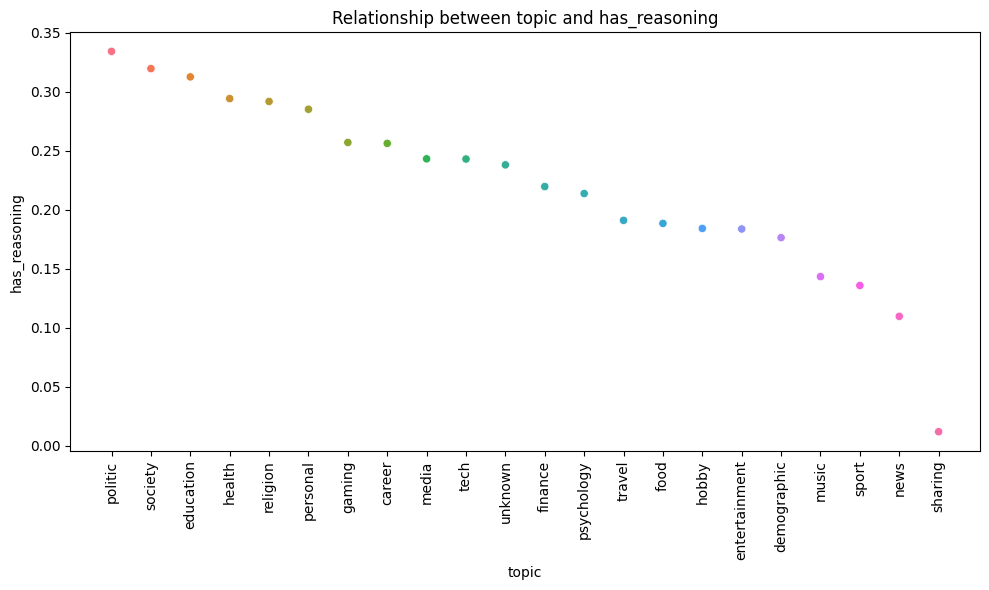

            topic  evidence
0            tech  0.351577
1           hobby  0.210872
2           music  0.206967
3          gaming  0.194651
4          travel  0.193089
5            food  0.186207
6         finance  0.180432
7          career  0.167085
8         unknown  0.154409
9         society  0.154206
10         health  0.146335
11          sport  0.138341
12           news  0.128049
13          media  0.121927
14        politic  0.109258
15  entertainment  0.103902
16      education  0.100548
17       religion  0.097480
18       personal  0.096315
19    demographic  0.091566
20        sharing  0.072289
21     psychology  0.055172


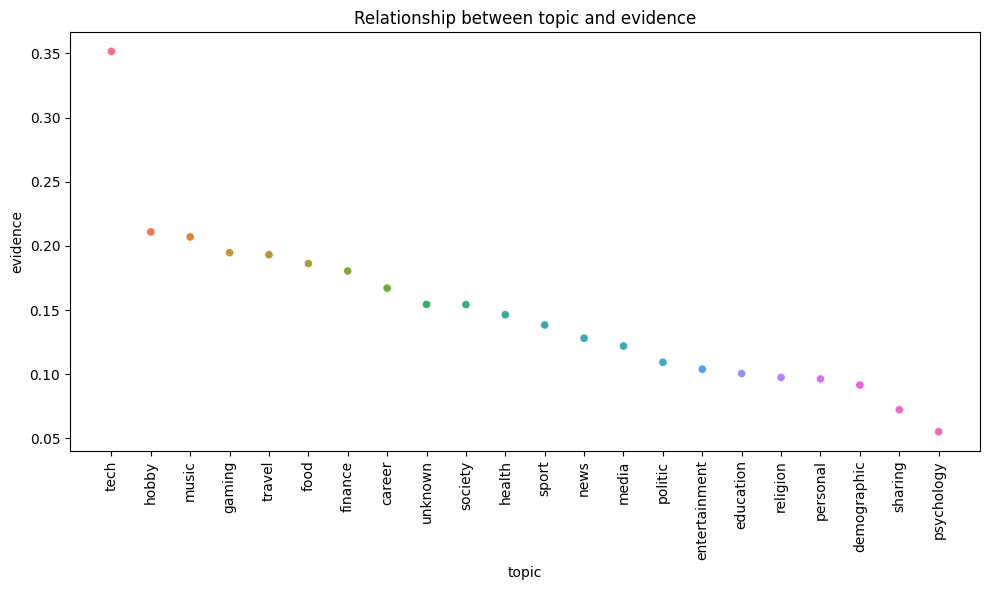

            topic  relatedness
0         politic     0.171592
1        religion     0.160167
2       education     0.140504
3        personal     0.139706
4      psychology     0.131779
5            tech     0.131278
6         unknown     0.126006
7          health     0.125722
8         finance     0.124145
9          career     0.123948
10         gaming     0.121682
11          media     0.119089
12         travel     0.118953
13        society     0.116847
14           food     0.113748
15          hobby     0.109740
16  entertainment     0.106643
17    demographic     0.099859
18           news     0.090555
19          music     0.089667
20          sport     0.081734
21        sharing     0.048657


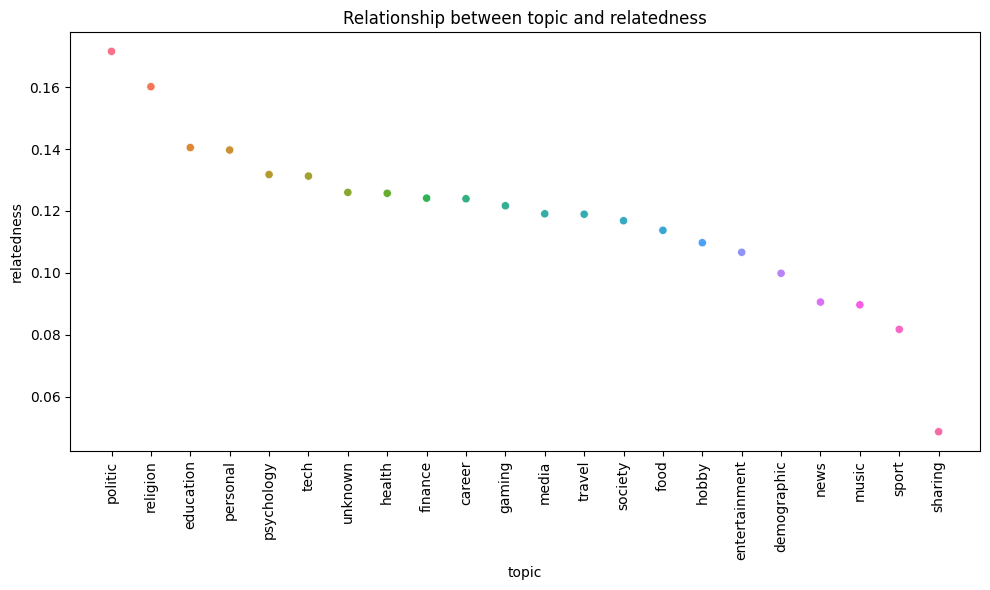

In [ ]:
for m in maxims:
  scatter_with_categorical(df, 'topic', m)

In [ ]:
# Perform the ANOVA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import numpy as np

def anova(df, cat_column, num_column):
    # Convert the categorical variable to a categorical type
    df[cat_column] = df[cat_column].astype('category')

    # Drop rows with NaN values
    df[cat_column] = df[cat_column].replace('unknown', np.nan)
    df = df.dropna(subset=[cat_column, num_column])

    model = ols(f'{num_column} ~ C({cat_column})', data=df).fit()
    anova_result = anova_lm(model, typ=2)

    # Print the ANOVA table
    print(anova_result)

# Call the function
anova(df, 'topic', 'mean_norm_politeness_replies')

              sum_sq       df          F  PR(>F)
C(topic)   29.506631     20.0  89.090629     0.0
Residual  621.824102  37550.0        NaN     NaN


In [ ]:
anova(df, 'topic', 'mean_norm_politeness_replies')

              sum_sq       df          F  PR(>F)
C(topic)   29.506631     20.0  89.090629     0.0
Residual  621.824102  37550.0        NaN     NaN


##Depth

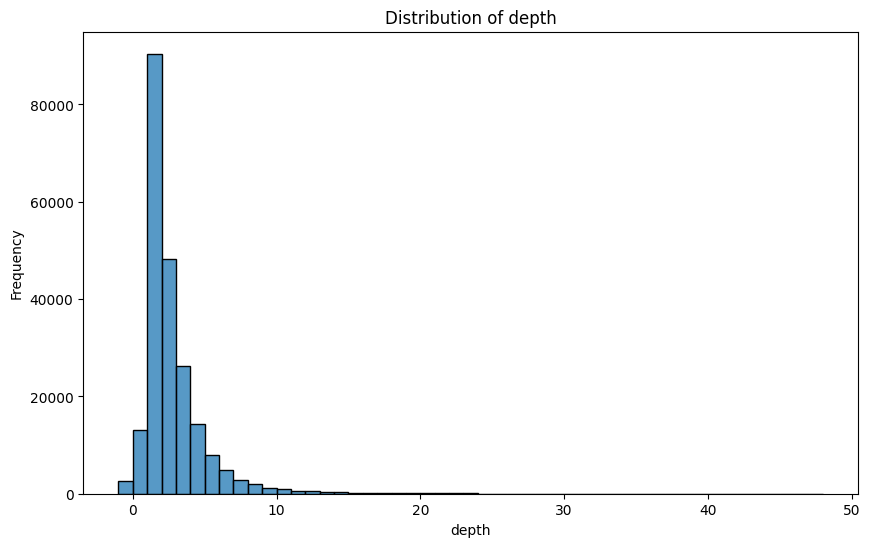

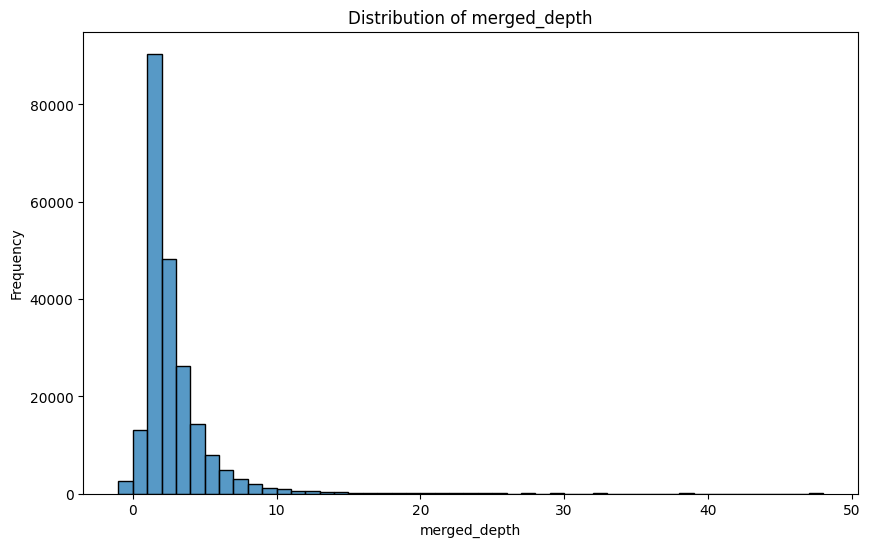

In [ ]:
plot_histogram(df, 'depth')
plot_histogram(df, 'merged_depth')

In [ ]:
def scater_plot_discrete_to_mean_all(df, column1, column2):
  # Group by depth and calculate mean score
  mean_scores = df.groupby(column1)[column2].mean().reset_index()

  scatter(mean_scores, column1, column2)

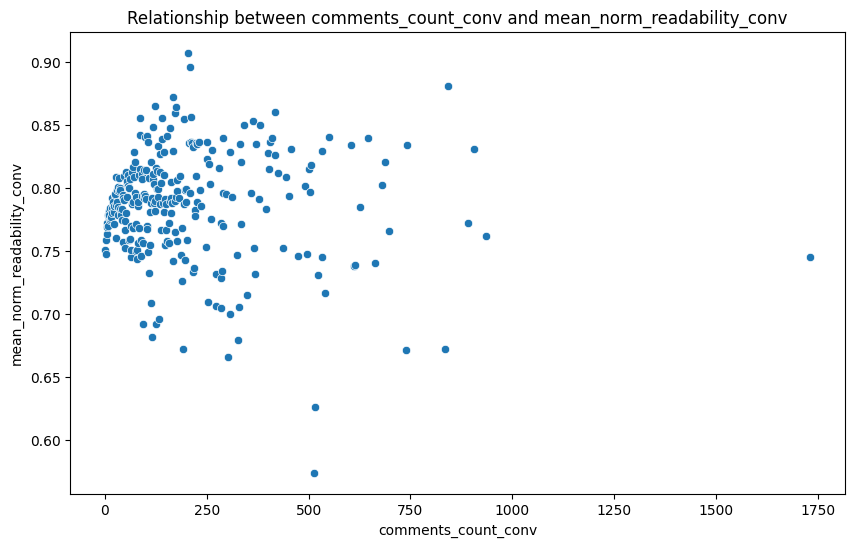

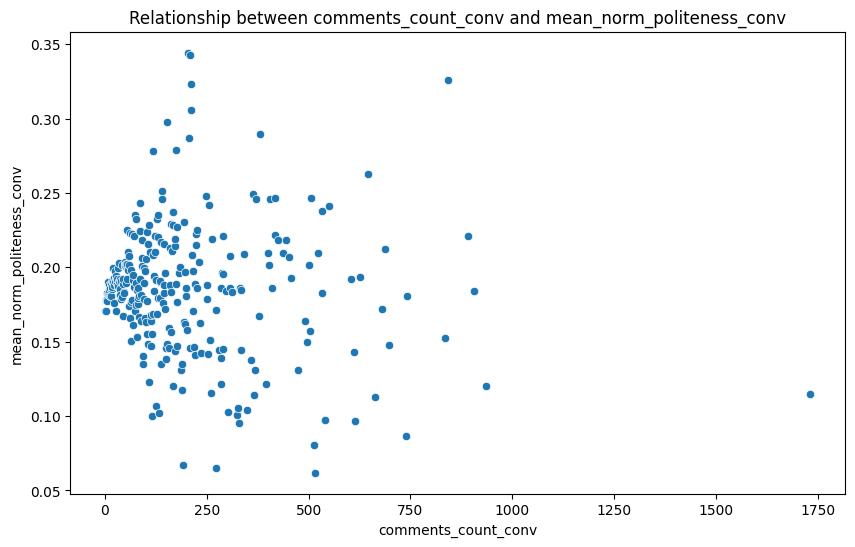

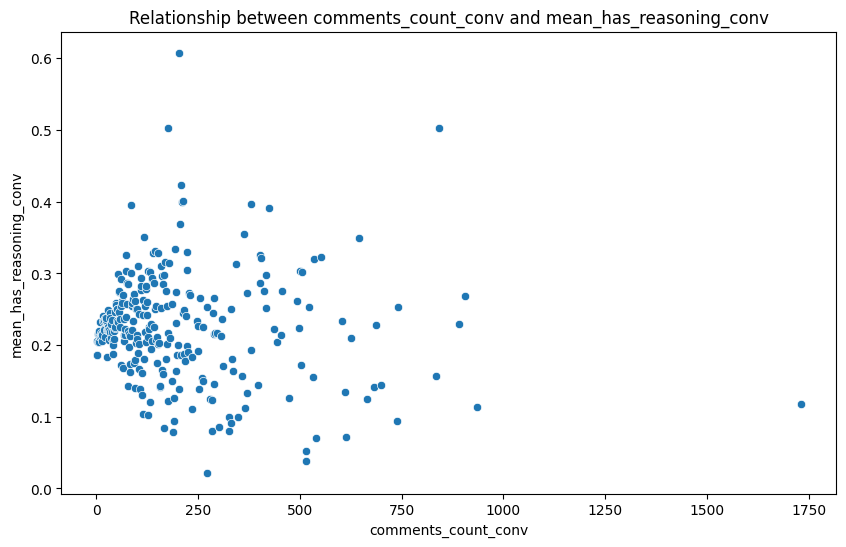

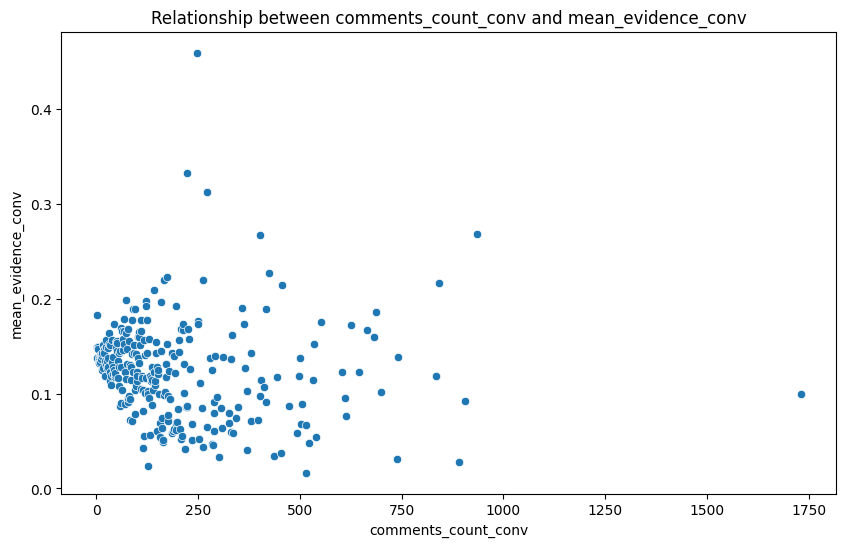

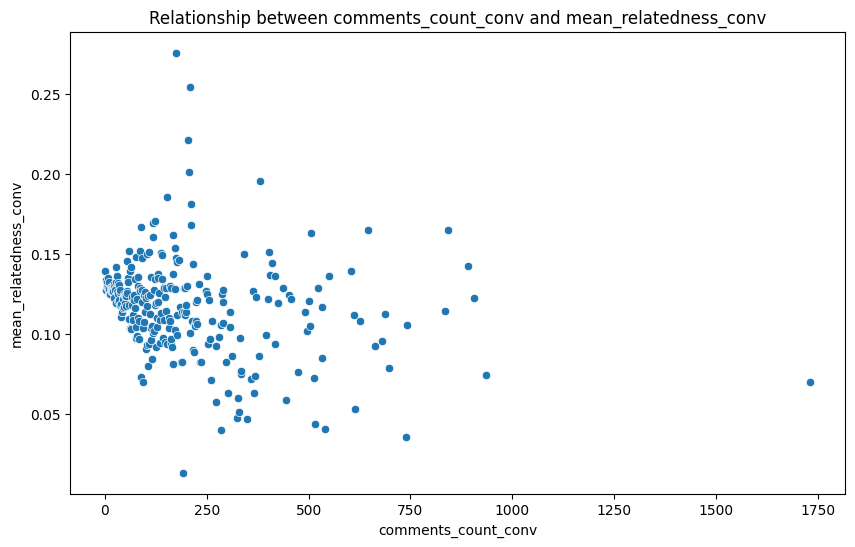

In [ ]:
for m in maxim_mean_over_conversations:
  scater_plot_discrete_to_mean_all(df, 'comments_count_conv', m)

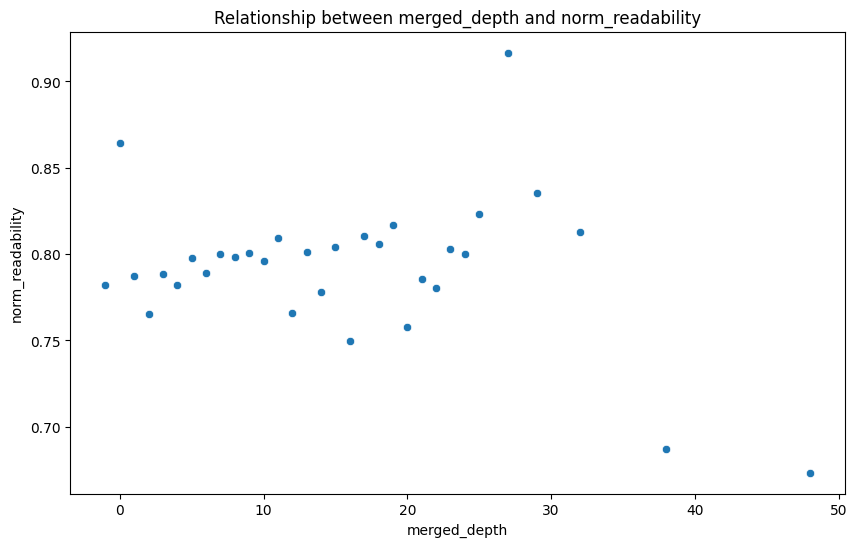

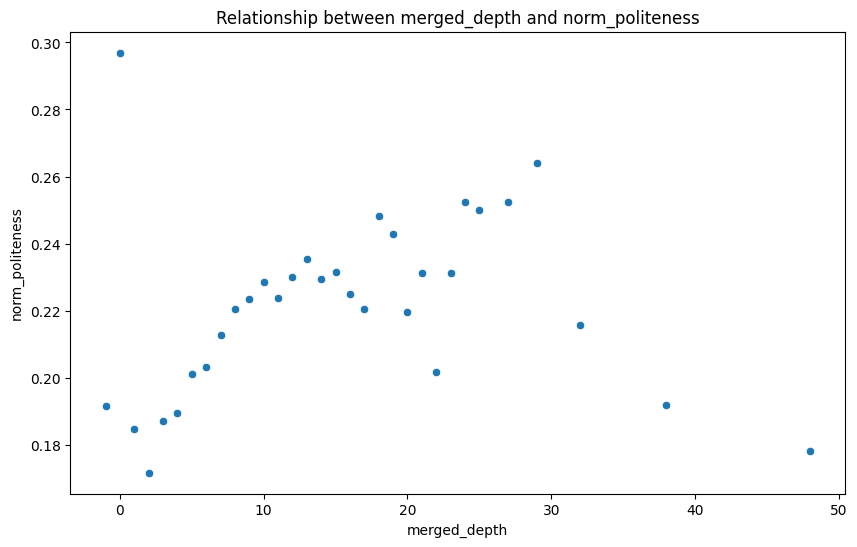

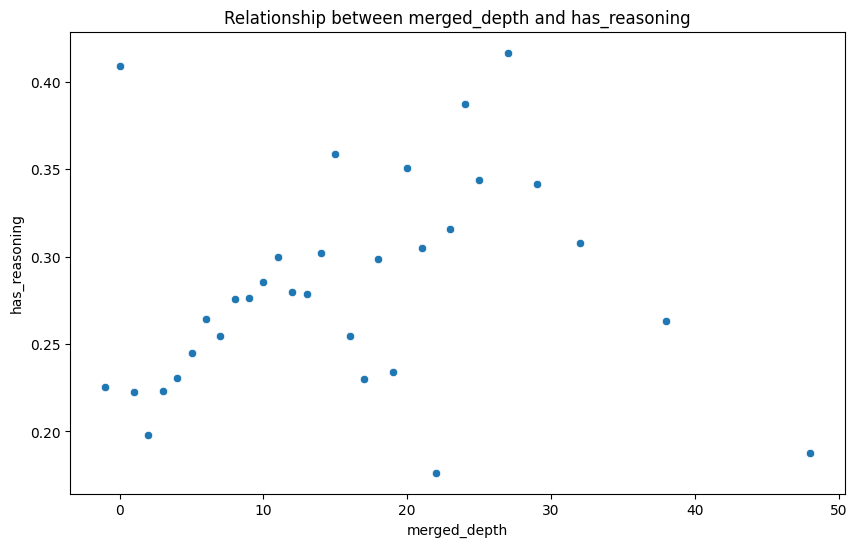

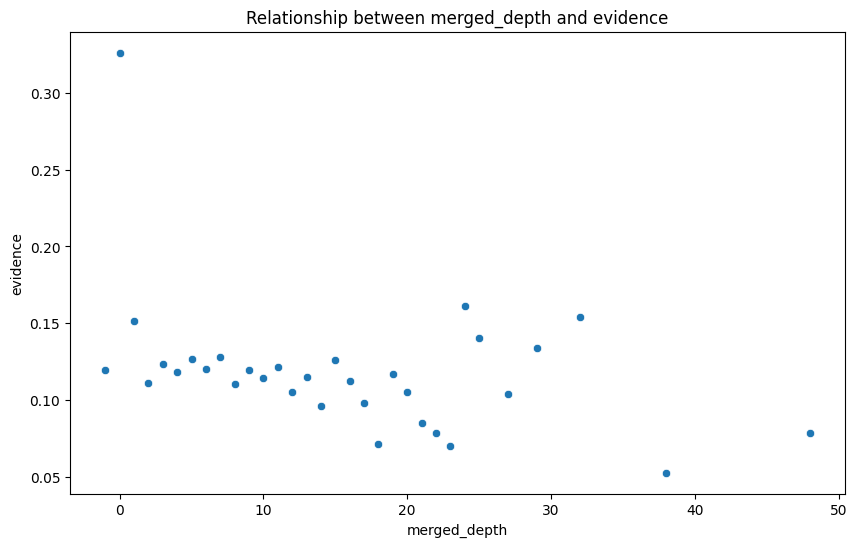

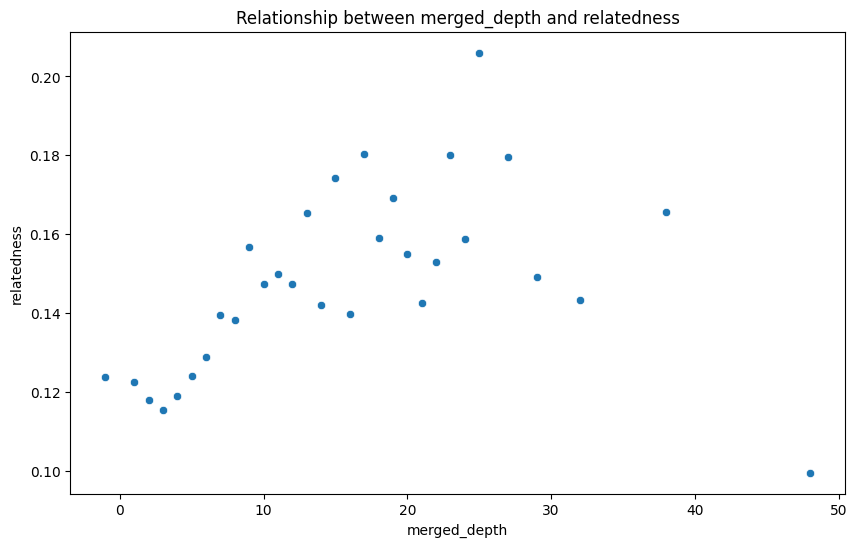

In [ ]:
for m in maxims:
  scater_plot_discrete_to_mean_all(df, 'merged_depth', m)

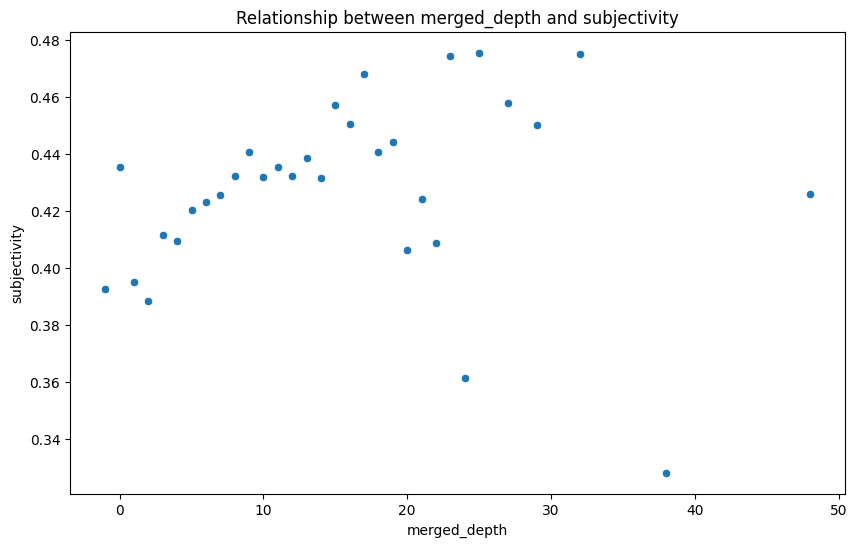

In [ ]:
scater_plot_discrete_to_mean_all(df, 'merged_depth', 'subjectivity')

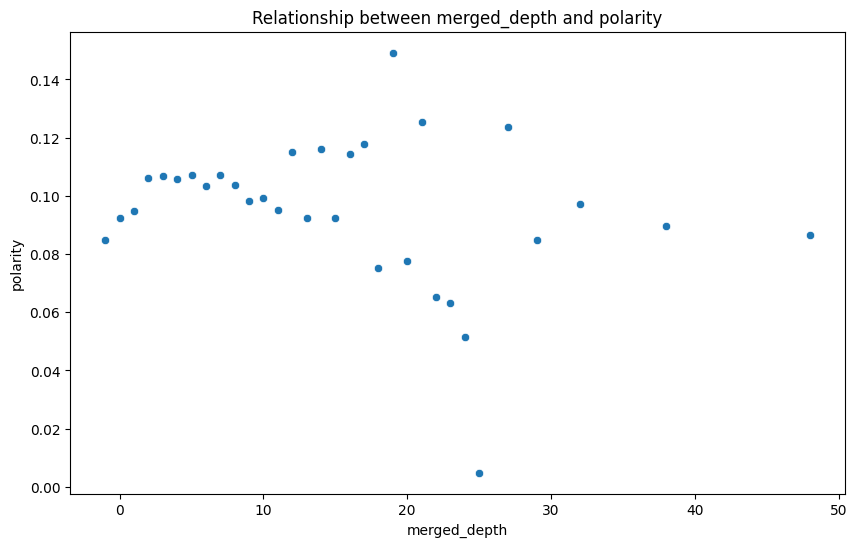

In [ ]:
scater_plot_discrete_to_mean_all(df, 'merged_depth', 'polarity')

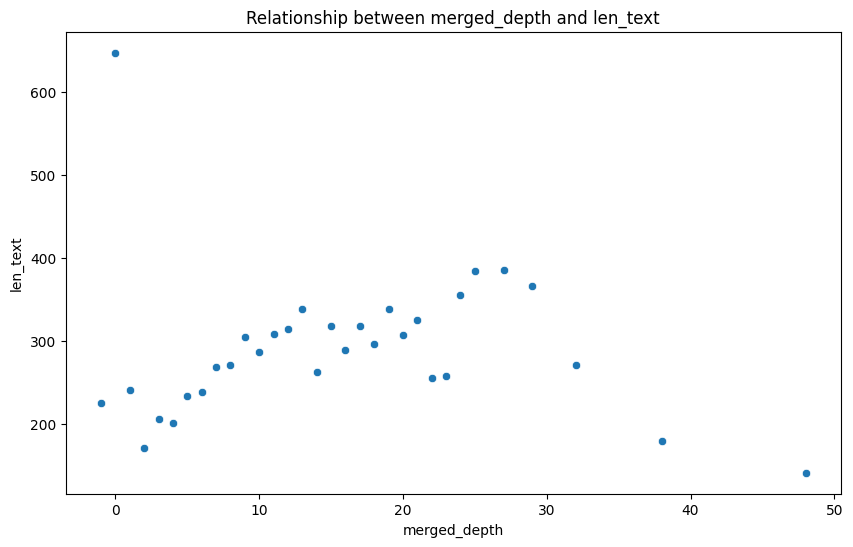

In [ ]:
scater_plot_discrete_to_mean_all(df, 'merged_depth', 'len_text')